# <a id='toc1_'></a>[Sensitivity by number of PLPs](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Sensitivity by number of PLPs](#toc1_)    
  - [Summary](#toc1_1_)    
  - [Data loading](#toc1_2_)    
  - [Split and filter data](#toc1_3_)    
    - [Split treated/control and filter infected cells](#toc1_3_1_)    
    - [QC: sample dropouts (no infected cells)](#toc1_3_2_)    
    - [Summarize spots per (infected) cell](#toc1_3_3_)    
    - [QC distribution of number of infected cells](#toc1_3_4_)    
    - [QC spot count outliers (failed segmentation):](#toc1_3_5_)    
    - [QC - bias when using all cells compared to inner cells](#toc1_3_6_)    
  - [Spots per (infected) cell](#toc1_4_)    
    - [QC consistency across replicates](#toc1_4_1_)    
  - [Median spot intensity](#toc1_5_)    
    - [QC intensity outliers](#toc1_5_1_)    
    - [Spot intensity by PLP count](#toc1_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Summary](#toc0_)

The following settings are used:
- only spots from infected cells (at least 5 spots), discarding all other spots - exception: negative controls (cells are not infected so we keep all spots)
- include spots from the cytoplasm and the nucleus
- include inner cells and border cells in the analysis (see QC below)
- do not crop images (neighboring fields of view have a slight overlap so counts from these FOVs are not completely independent, this could be problematic for statistical tests (not performed here))

General observations:
- sensitivity in terms of spot counts increases with number of PLPs but saturates around 6 PLP
- the spot intensity seams to slightly increase with number of PLPs, but this trend is not very strong

## <a id='toc1_2_'></a>[Data loading](#toc0_)

In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 4)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

In [3]:
spots <- read_tsv("analysis/spot_detection/plp_cumulative/all_spots.tsv.xz", na="")

Rows: 2333247 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): rep, segment, sample, fov
dbl (17): intensity, z, y, x, radius, spot_id, z_min, z_max, y_min, y_max, x...
lgl  (2): nucleus, border_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## <a id='toc1_3_'></a>[Split and filter data](#toc0_)

For negative controls, all spots are used and the number of spots per cell is calculated. For all other samples, only spots from *infected* cells are used and the number of spots per infected cell is calculated.
A cell is defined as *infected* if at least 5 spots are assigned to that cell, including the nucleus.

Separate datasets are created where all the border_cells are filtered out. Those are prefixed with `inner_`.

### <a id='toc1_3_1_'></a>[Split treated/control and filter infected cells](#toc0_)

In [4]:
pos_spots <- spots %>%
	filter(!str_detect(sample,"NegCtrl")) %>%
	group_by(rep,segment,sample,fov,cell) %>%
	filter(n()>=5) %>%
	group_by(rep,segment,sample,fov) %>%
	mutate(infected_cells=n_distinct(cell))

In [5]:
inner_pos_spots <- pos_spots %>%
	filter(!border_cell) %>%
	group_by(rep,segment,sample,fov) %>%
	mutate(infected_cells=n_distinct(cell))

In [6]:
neg_spots <- spots %>%
	filter(str_detect(sample,"NegCtrl"))

In [7]:
inner_neg_spots <- neg_spots %>%
	filter(!border_cell) %>%
	group_by(rep,segment,sample,fov) %>%
	mutate(n_cells=n_distinct(cell))

### <a id='toc1_3_2_'></a>[QC: sample dropouts (no infected cells)](#toc0_)

After filtering cells with less than 5 spots, some samples are lost as they don't contain any infected cells

In [8]:
get_fovs <- . %>% ungroup %>% select(rep,segment,sample,fov) %>% unique

In [9]:
fovs_no_infected_cells <- get_fovs(spots %>% filter(!str_detect(sample,"NegCtrl"))) %>% anti_join(get_fovs(pos_spots))
fovs_no_infected_cells

Joining with `by = join_by(rep, segment, sample, fov)`


rep,segment,sample,fov
<chr>,<chr>,<chr>,<chr>
rep0,PB1,1PLP,fov_4
rep1,HA,3PLP,fov_6
rep2,NA,1PLP,fov_7
rep2,PB1,6PLP,fov_1


### <a id='toc1_3_3_'></a>[Summarize spots per (infected) cell](#toc0_)

In [10]:
pos_spots_summary <- pos_spots %>% group_by(rep,segment,sample,fov,infected_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_infected_cell = spots/infected_cells)
neg_spots_summary <- neg_spots %>% group_by(rep,segment,sample,fov,n_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_cell = spots/n_cells)
inner_pos_spots_summary <- inner_pos_spots %>% group_by(rep,segment,sample,fov,infected_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_infected_cell = spots/infected_cells)
inner_neg_spots_summary <- inner_neg_spots %>% group_by(rep,segment,sample,fov,n_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_cell = spots/n_cells)

`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'segment', 'sample', 'fov'. You can
override using the `.groups` argument.


### <a id='toc1_3_4_'></a>[QC distribution of number of infected cells](#toc0_)

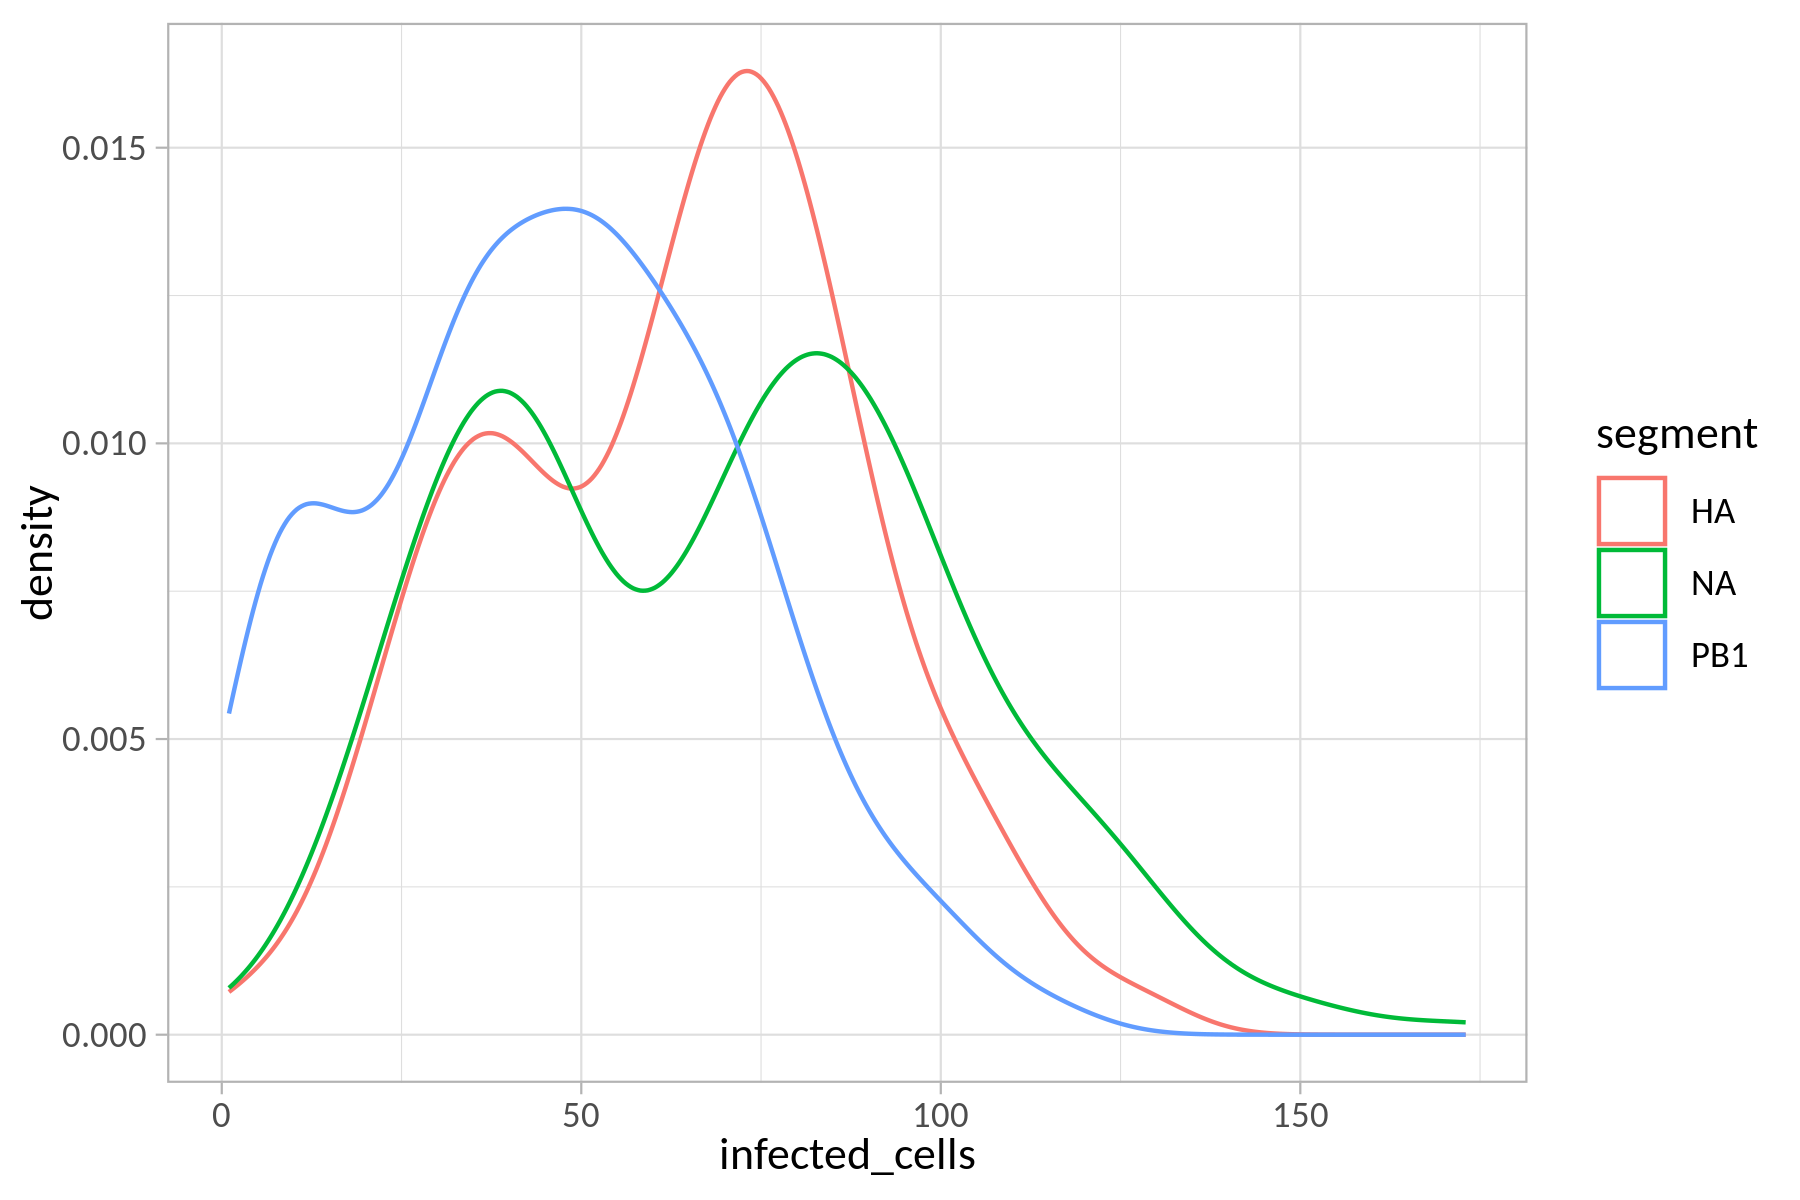

In [11]:
pos_spots_summary %>% ggplot(aes(x=infected_cells, color=segment)) + geom_density()

### <a id='toc1_3_5_'></a>[QC spot count outliers (failed segmentation):](#toc0_)

In some cases the segmentation failed and very few nuclei were detected, therefore the spots/cell count is massively inflated. Those samples need to be filtered.

In [12]:
pos_spots_summary %>% filter(spots_per_infected_cell>1000)

rep,segment,sample,fov,infected_cells,spots,median_intensity,mean_radius,spots_per_infected_cell
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
rep0,HA,10PLP,fov_7,4,5146,0.0185626,3,1286.5


In [13]:
pos_spots_summary <- pos_spots_summary %>% filter(spots_per_infected_cell < 1000)
neg_spots_summary <- neg_spots_summary %>% filter(spots_per_cell < 1000)

### <a id='toc1_3_6_'></a>[QC - bias when using all cells compared to inner cells](#toc0_)

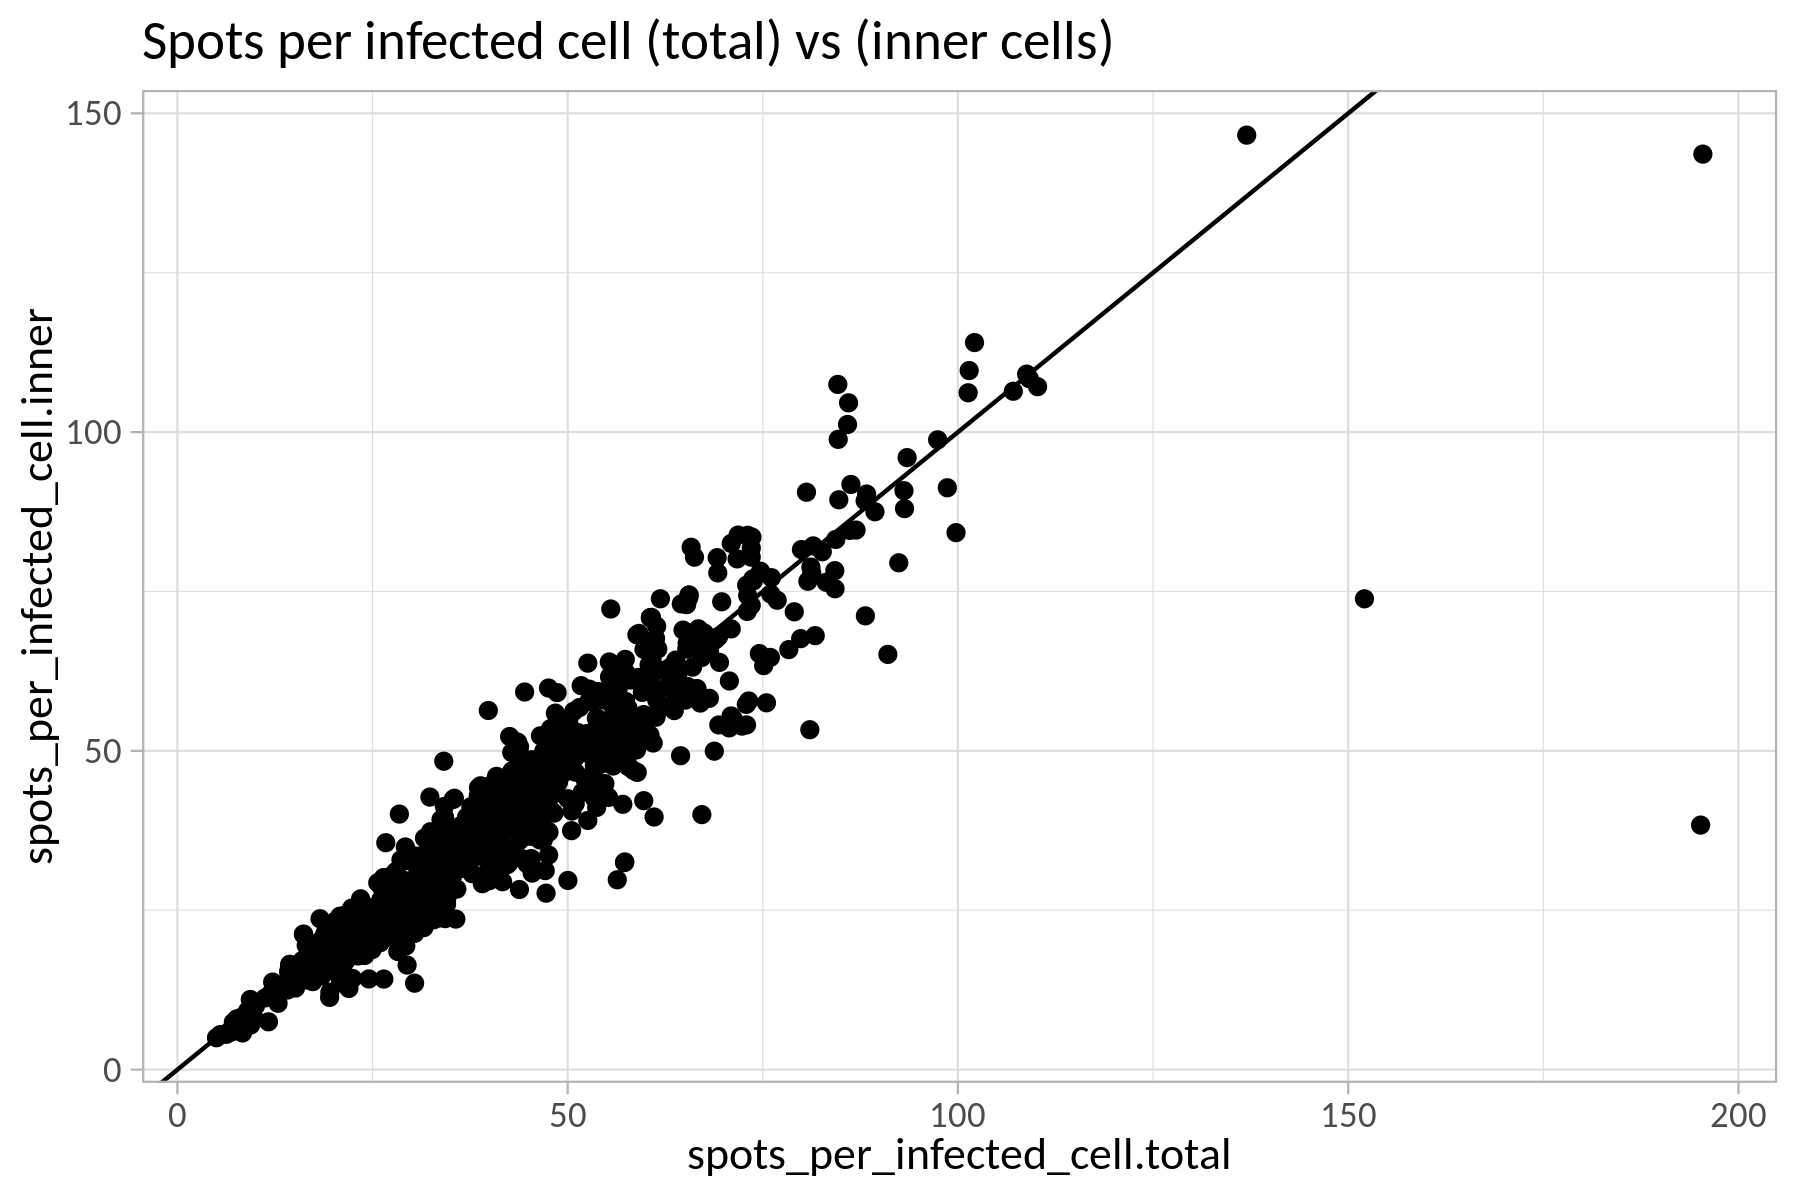

In [14]:
left_join(pos_spots_summary, inner_pos_spots_summary, by = join_by(rep, segment, sample, fov), suffix=c(".total", ".inner")) %>%
	ggplot(aes(spots_per_infected_cell.total, spots_per_infected_cell.inner)) +
		geom_point() +
		geom_abline(slope=1, intercept=0) +
		#scale_x_continuous(breaks = seq(0, 1000, by = 100)) +
		#scale_y_continuous(breaks = seq(0, 1000, by = 100)) +
		ggtitle("Spots per infected cell (total) vs (inner cells)")

Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”


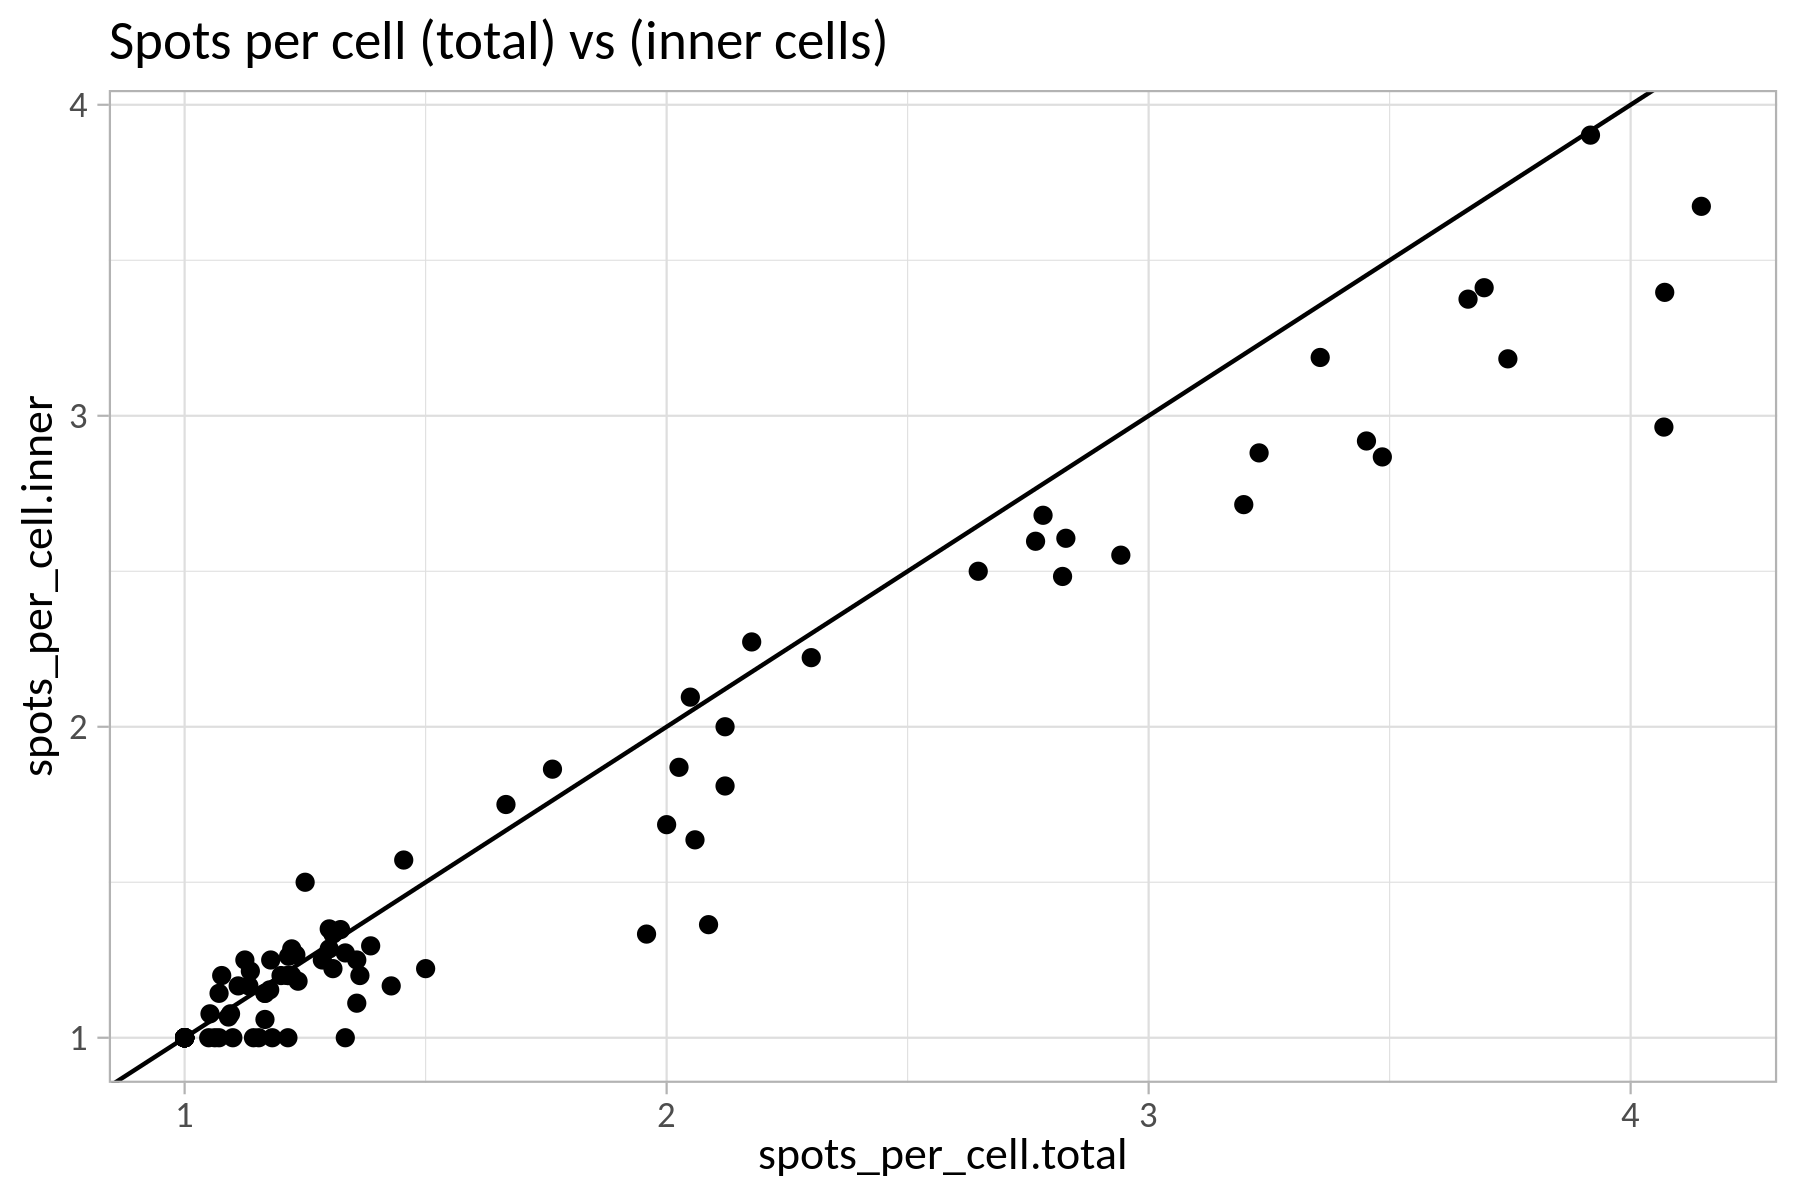

In [15]:
left_join(neg_spots_summary, inner_neg_spots_summary, by = join_by(rep, segment, sample, fov), suffix=c(".total", ".inner")) %>%
	ggplot(aes(spots_per_cell.total, spots_per_cell.inner)) +
		geom_point() +
		geom_abline(slope=1, intercept=0) +
		#scale_x_continuous(breaks = seq(0, 1000, by = 100)) +
		#scale_y_continuous(breaks = seq(0, 1000, by = 100)) +
		ggtitle("Spots per cell (total) vs (inner cells)")

**⇒ There is almost no difference in spots per (infected) cells when restricting to inner cells. So all cells can be used.**

## <a id='toc1_4_'></a>[Spots per (infected) cell](#toc0_)

In [16]:
pos_plot <- pos_spots_summary %>%
	mutate(plp = parse_number(sample)) %>%
	ggplot(aes(plp,spots_per_infected_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=plp), outlier.shape = NA) +
		geom_smooth() +
		facet_grid(segment ~ .) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		ylim(0,100) +
		xlab("PLPs per target") + ylab("") +
		# scale_y_log10() +
		NULL

In [17]:
options(repr.plot.width = 1.5)
neg_plot <- neg_spots_summary %>%
	ggplot(aes(sample,spots_per_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		facet_grid(segment ~ .) +
		ylim(0,100) +
		scale_x_discrete(breaks = NULL) +
		xlab("Neg. Control") + ylab("RCPs per (infected) cells") +
		NULL
options(repr.plot.width = 7)

Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 11 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”


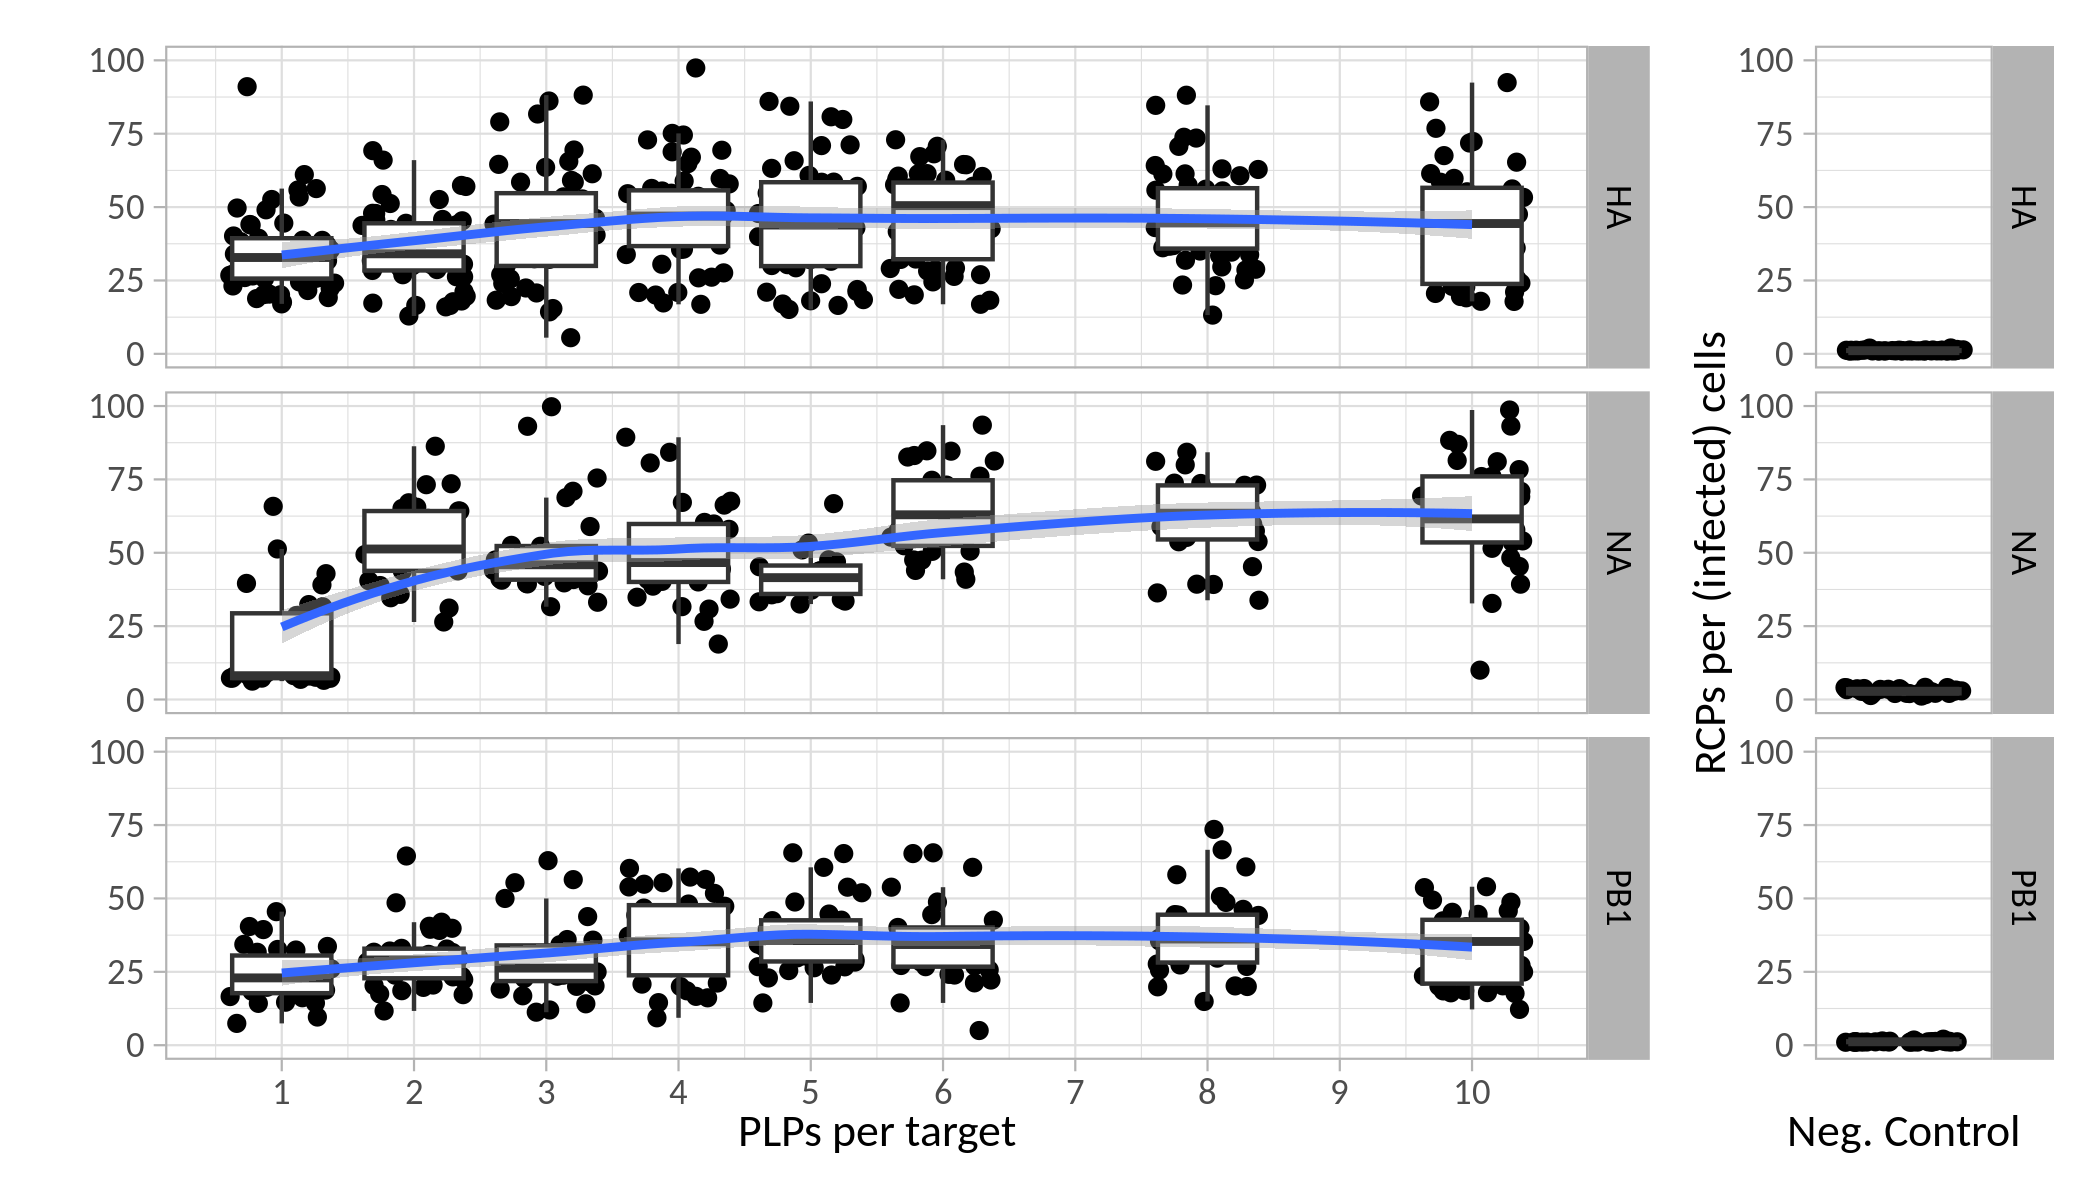

In [18]:
pos_plot + neg_plot + plot_layout(widths = c(8, 1)) #& scale_y_continuous(limits = c(0, 45)) 

In [19]:
pos_plot_na <- pos_spots_summary %>%
	filter(segment == "NA") %>%
	mutate(plp = parse_number(sample)) %T>%
	write_tsv("figures/fig2fg-plp_cumulative-spot_counts_NA_pos.tsv") %>%
	ggplot(aes(plp,spots_per_infected_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=plp), outlier.shape = NA) +
		geom_smooth(se=FALSE) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		ylim(0,100) +
		xlab("PLPs per target") + ylab("RCPs per infected cells")

In [20]:
neg_plot_na <- neg_spots_summary %>%
	filter(segment == "NA") %T>%
	write_tsv("figures/fig2fg-plp_cumulative-spot_counts_NA_neg.tsv") %>%
	ggplot(aes(sample,spots_per_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		ylim(0,100) +
		scale_x_discrete(breaks = NULL) +
		xlab("Neg. Control") + ylab("RCPs per cells")

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


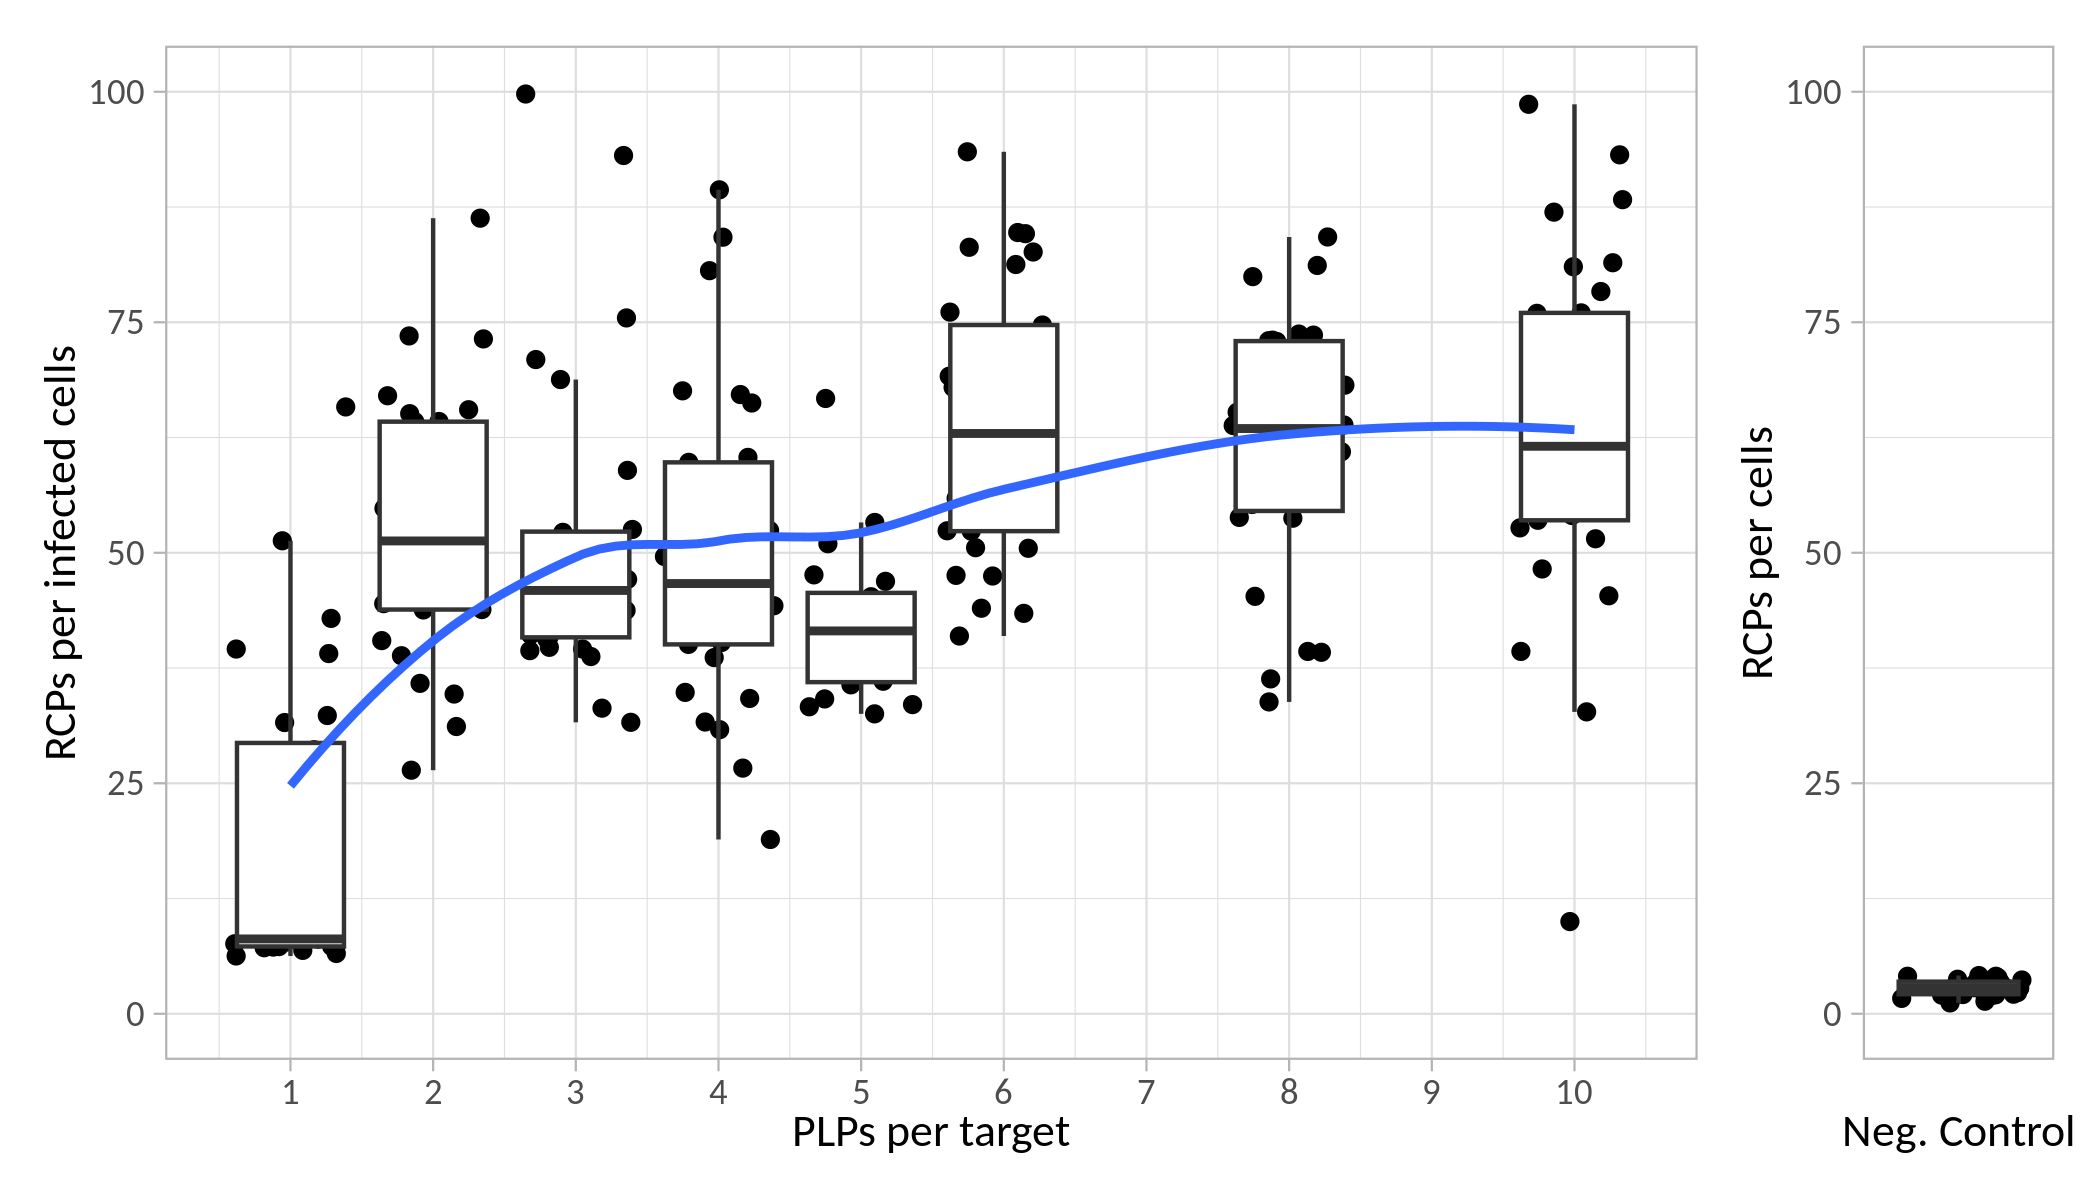

In [21]:
pos_plot_na + neg_plot_na + plot_layout(widths = c(8, 1)) +#& scale_y_continuous(limits = c(0, 45)) 
		NULL

In [22]:
ggsave("figures/fig2fg-plp_cumulative-spot_counts_NA.svg", width = 6, height = 3, dpi = 300)

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


In [23]:
pos_plot_ha <- pos_spots_summary %>%
	filter(segment == "HA") %>%
	mutate(plp = parse_number(sample)) %T>%
	write_tsv("figures/supp-fig2fg-plp_cumulative-spot_counts_HA_pos.tsv") %>%
	ggplot(aes(plp,spots_per_infected_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=plp), outlier.shape = NA) +
		geom_smooth(se=FALSE) +
		scale_x_continuous(breaks = seq(1, 10, by = 1)) +
		ylim(0,100) +
		xlab("PLPs per target") + ylab("RCPs per infected cells")

In [24]:
neg_plot_ha <- neg_spots_summary %>%
	filter(segment == "HA") %T>%
	write_tsv("figures/supp-fig2fg-plp_cumulative-spot_counts_HA_neg.tsv") %>%
	ggplot(aes(sample,spots_per_cell))+#,color=segment)) +
		geom_jitter()+#aes(color=rep)) +
		geom_boxplot(aes(group=sample), outlier.shape = NA) +
		ylim(0,100) +
		scale_x_discrete(breaks = NULL) +
		xlab("Neg. Control") + ylab("RCPs per cells")

Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


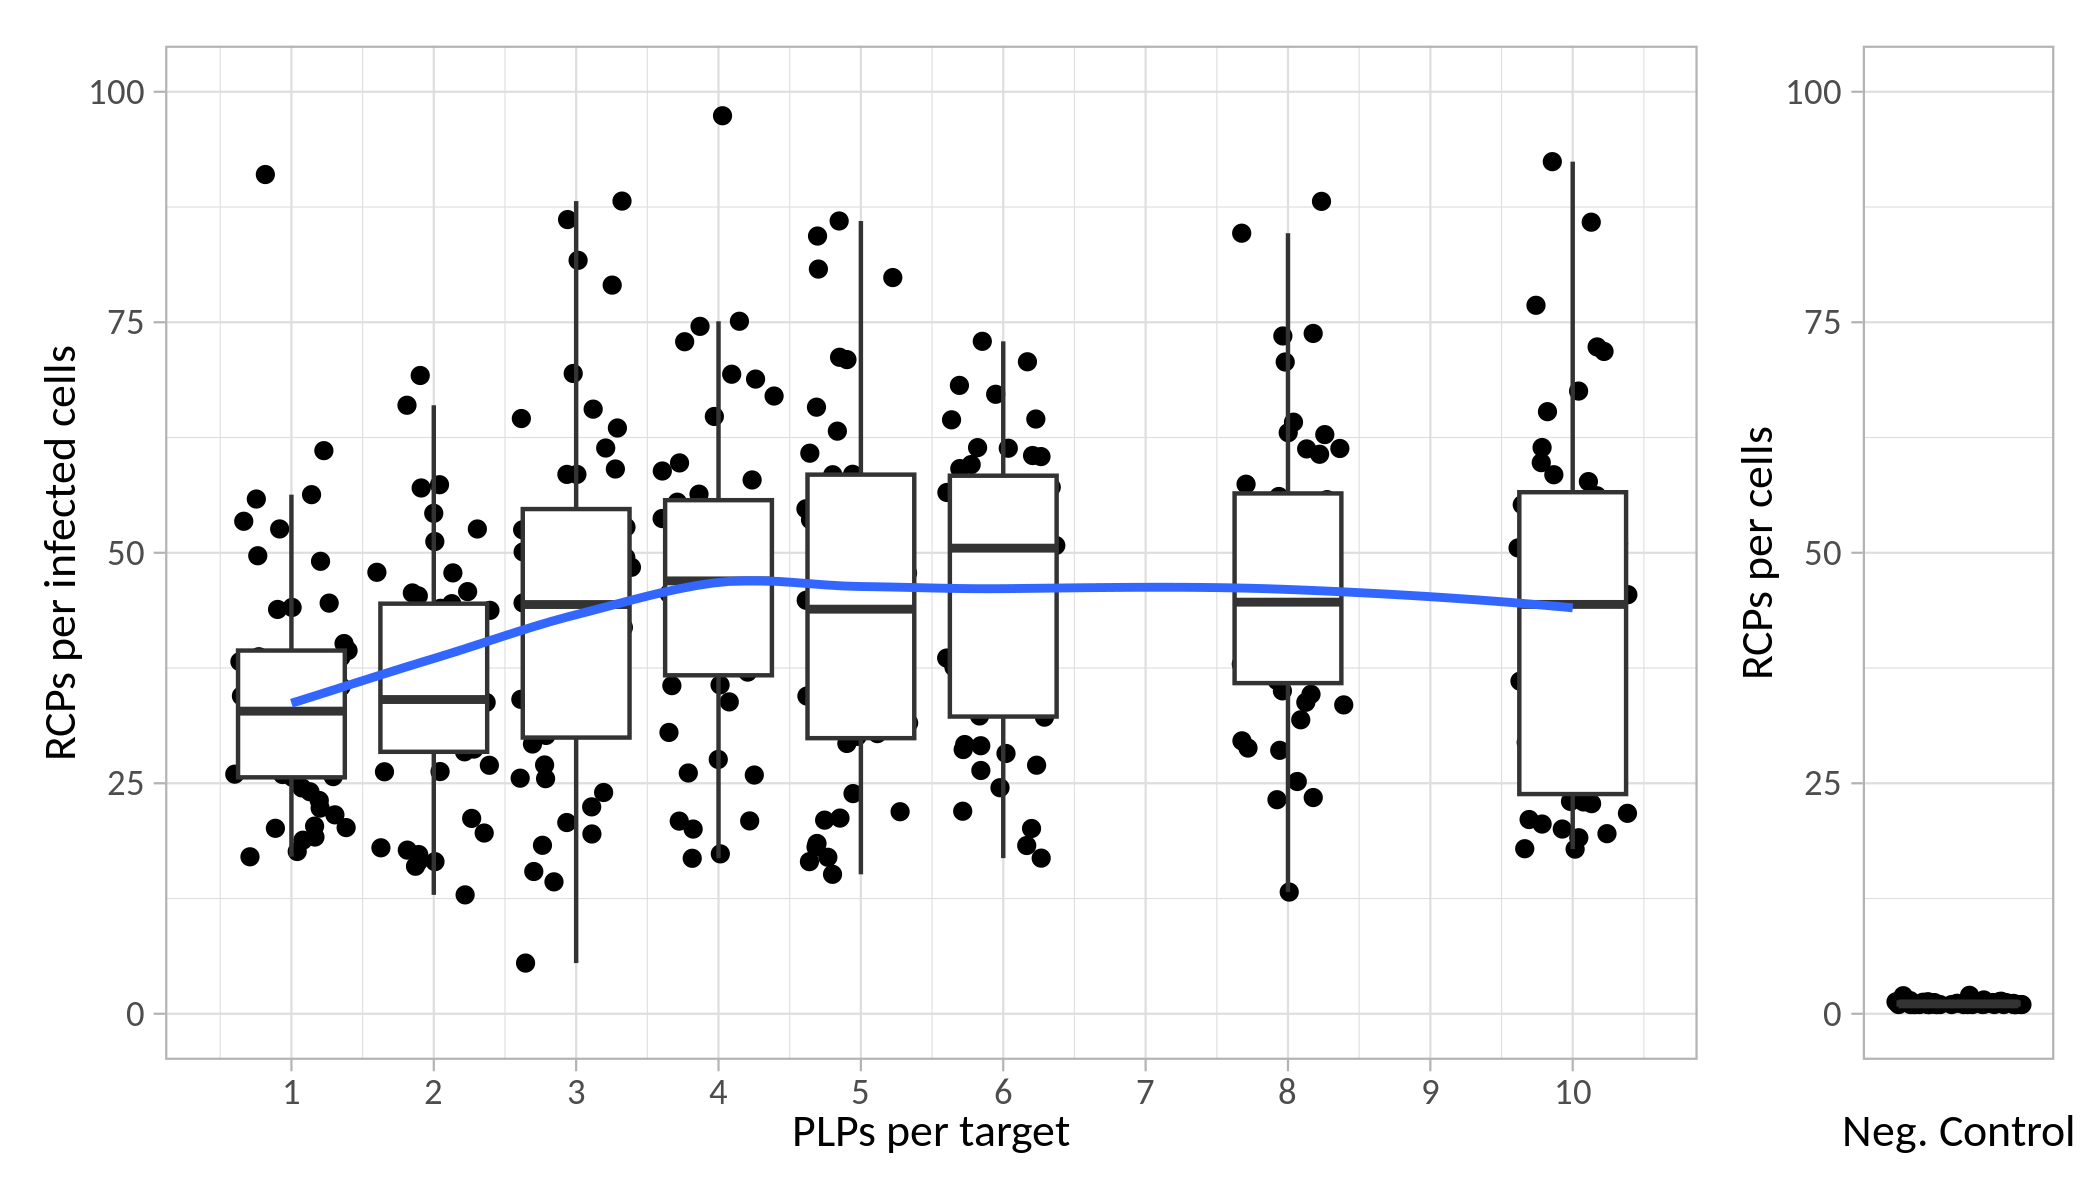

In [25]:
pos_plot_ha + neg_plot_ha + plot_layout(widths = c(8, 1)) +#& scale_y_continuous(limits = c(0, 45)) 
		NULL

In [26]:
ggsave("figures/supp-fig2fg-plp_cumulative-spot_counts_HA.svg", width = 6, height = 3, dpi = 300)

Warning message:
“Removed 8 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


### <a id='toc1_4_1_'></a>[QC consistency across replicates](#toc0_)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


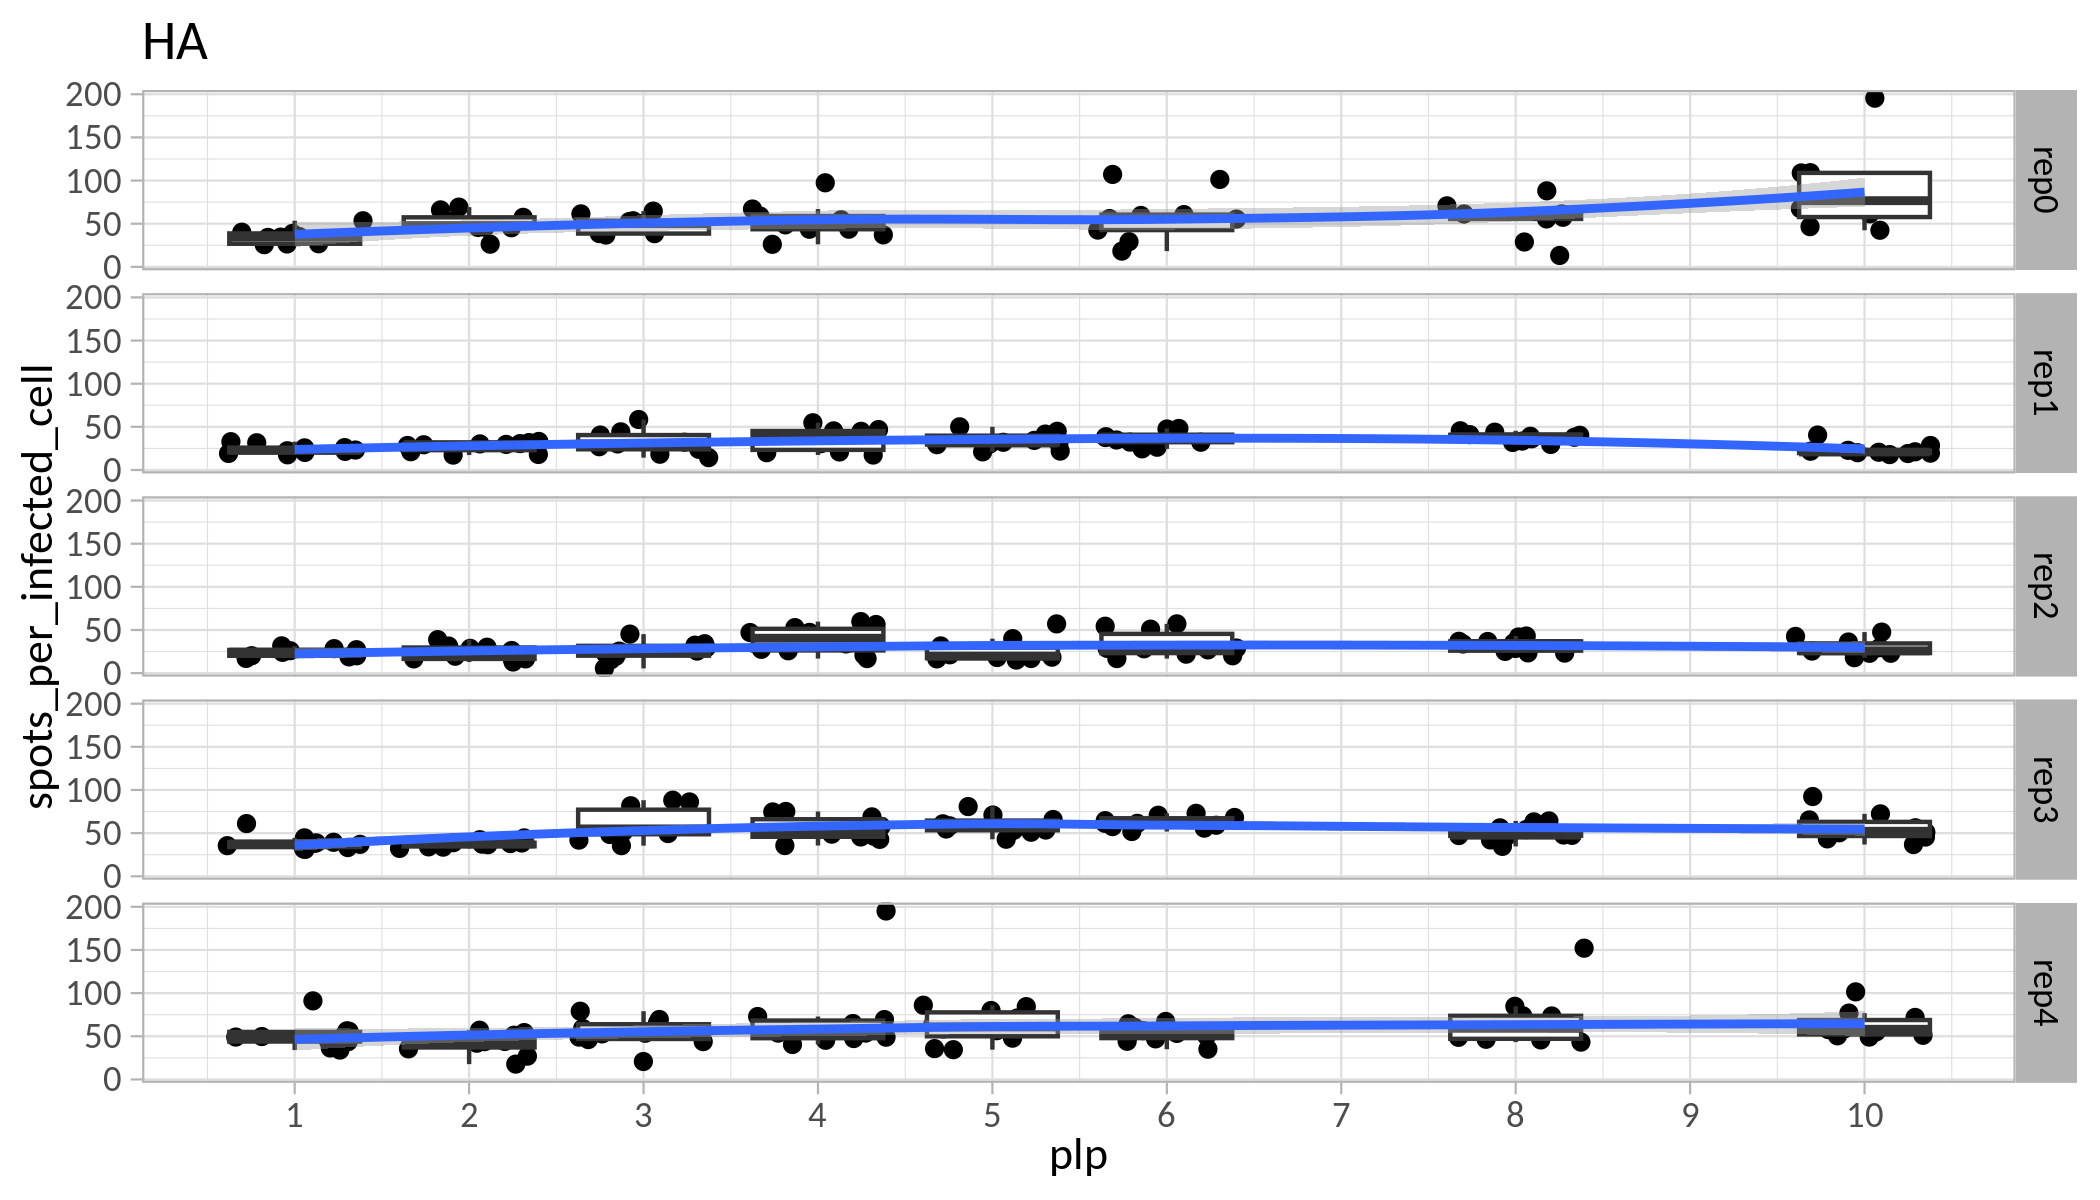

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


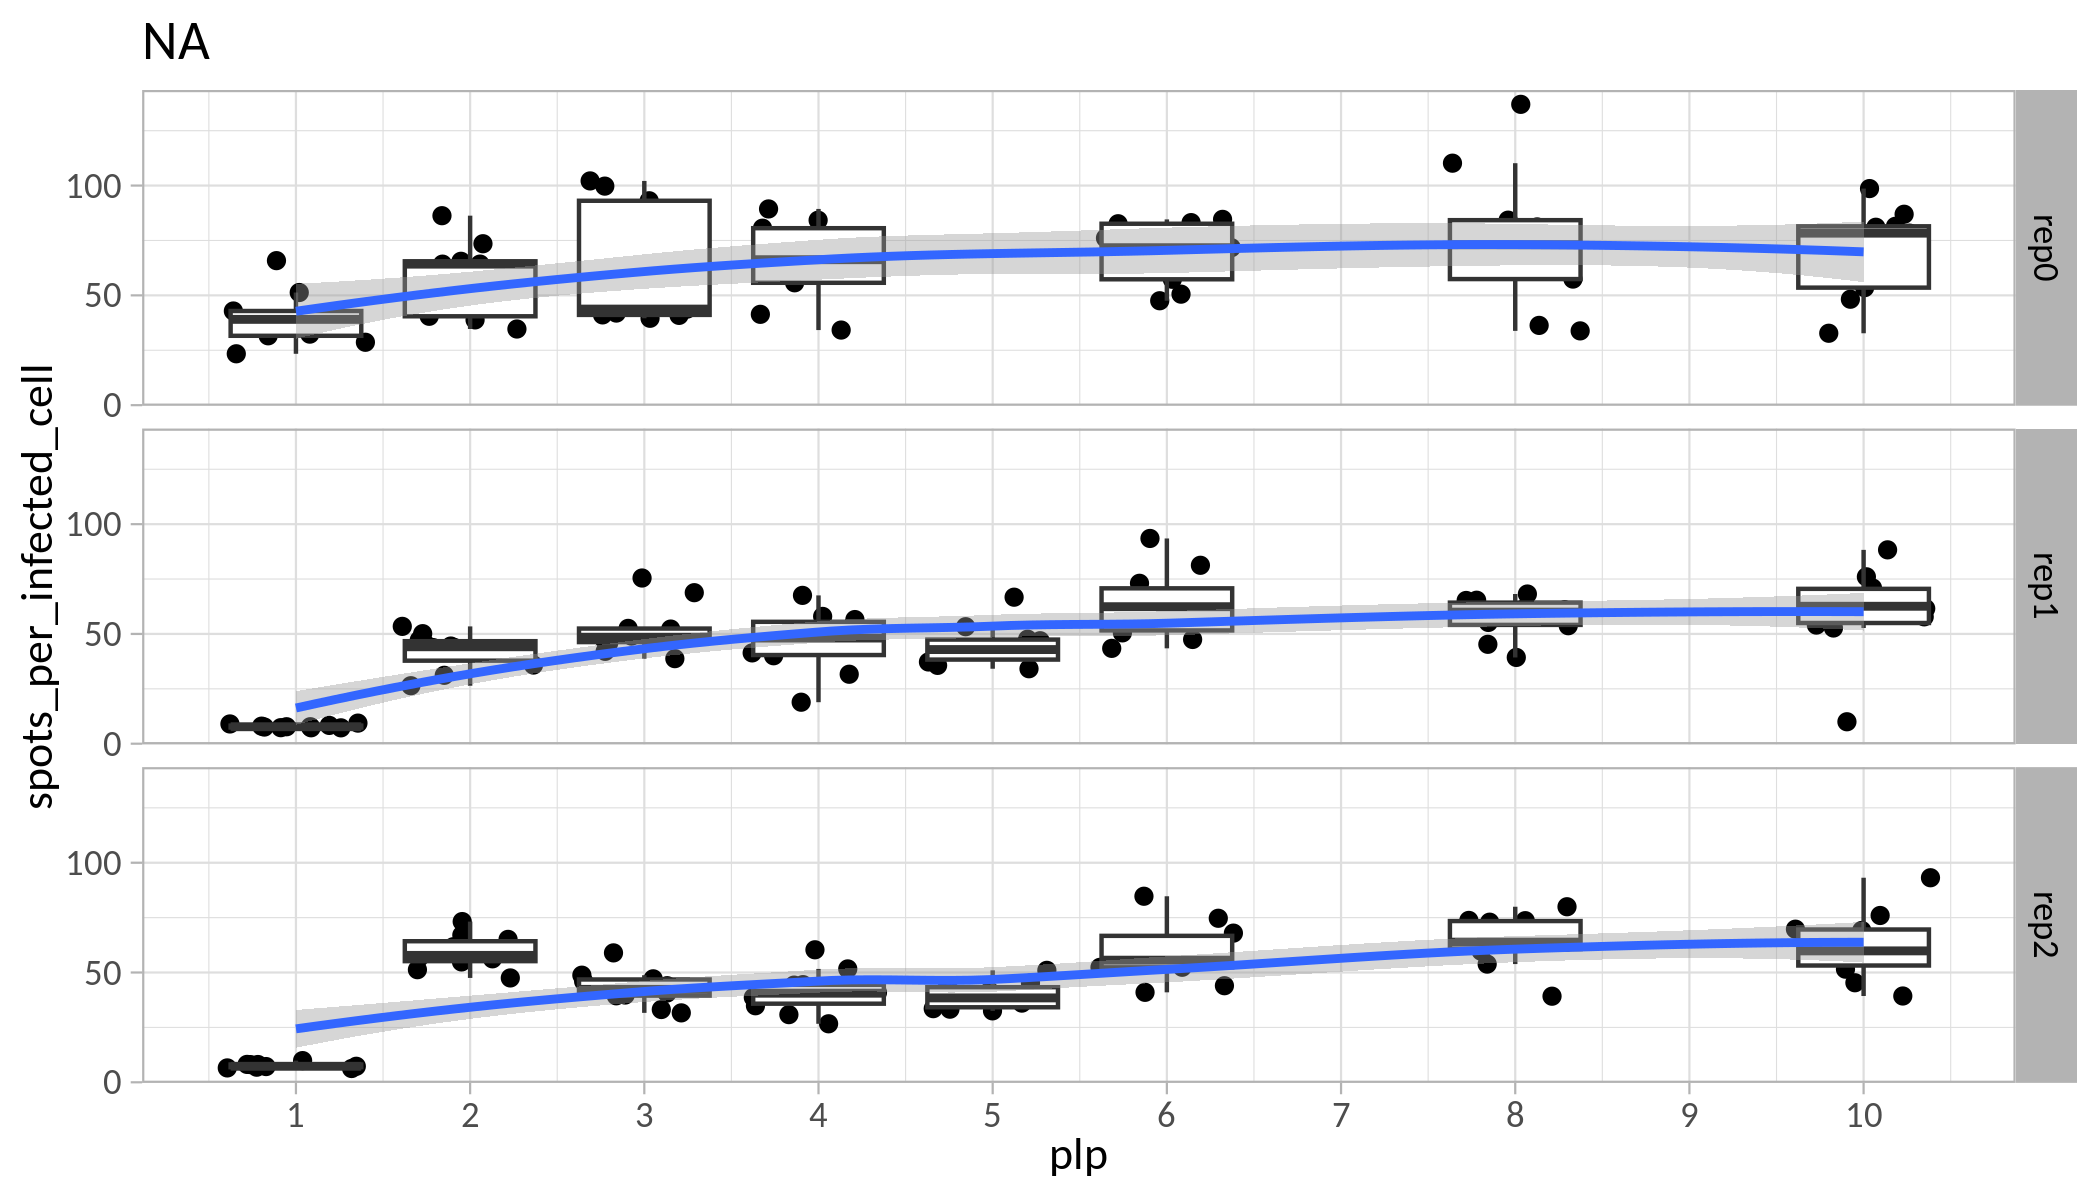

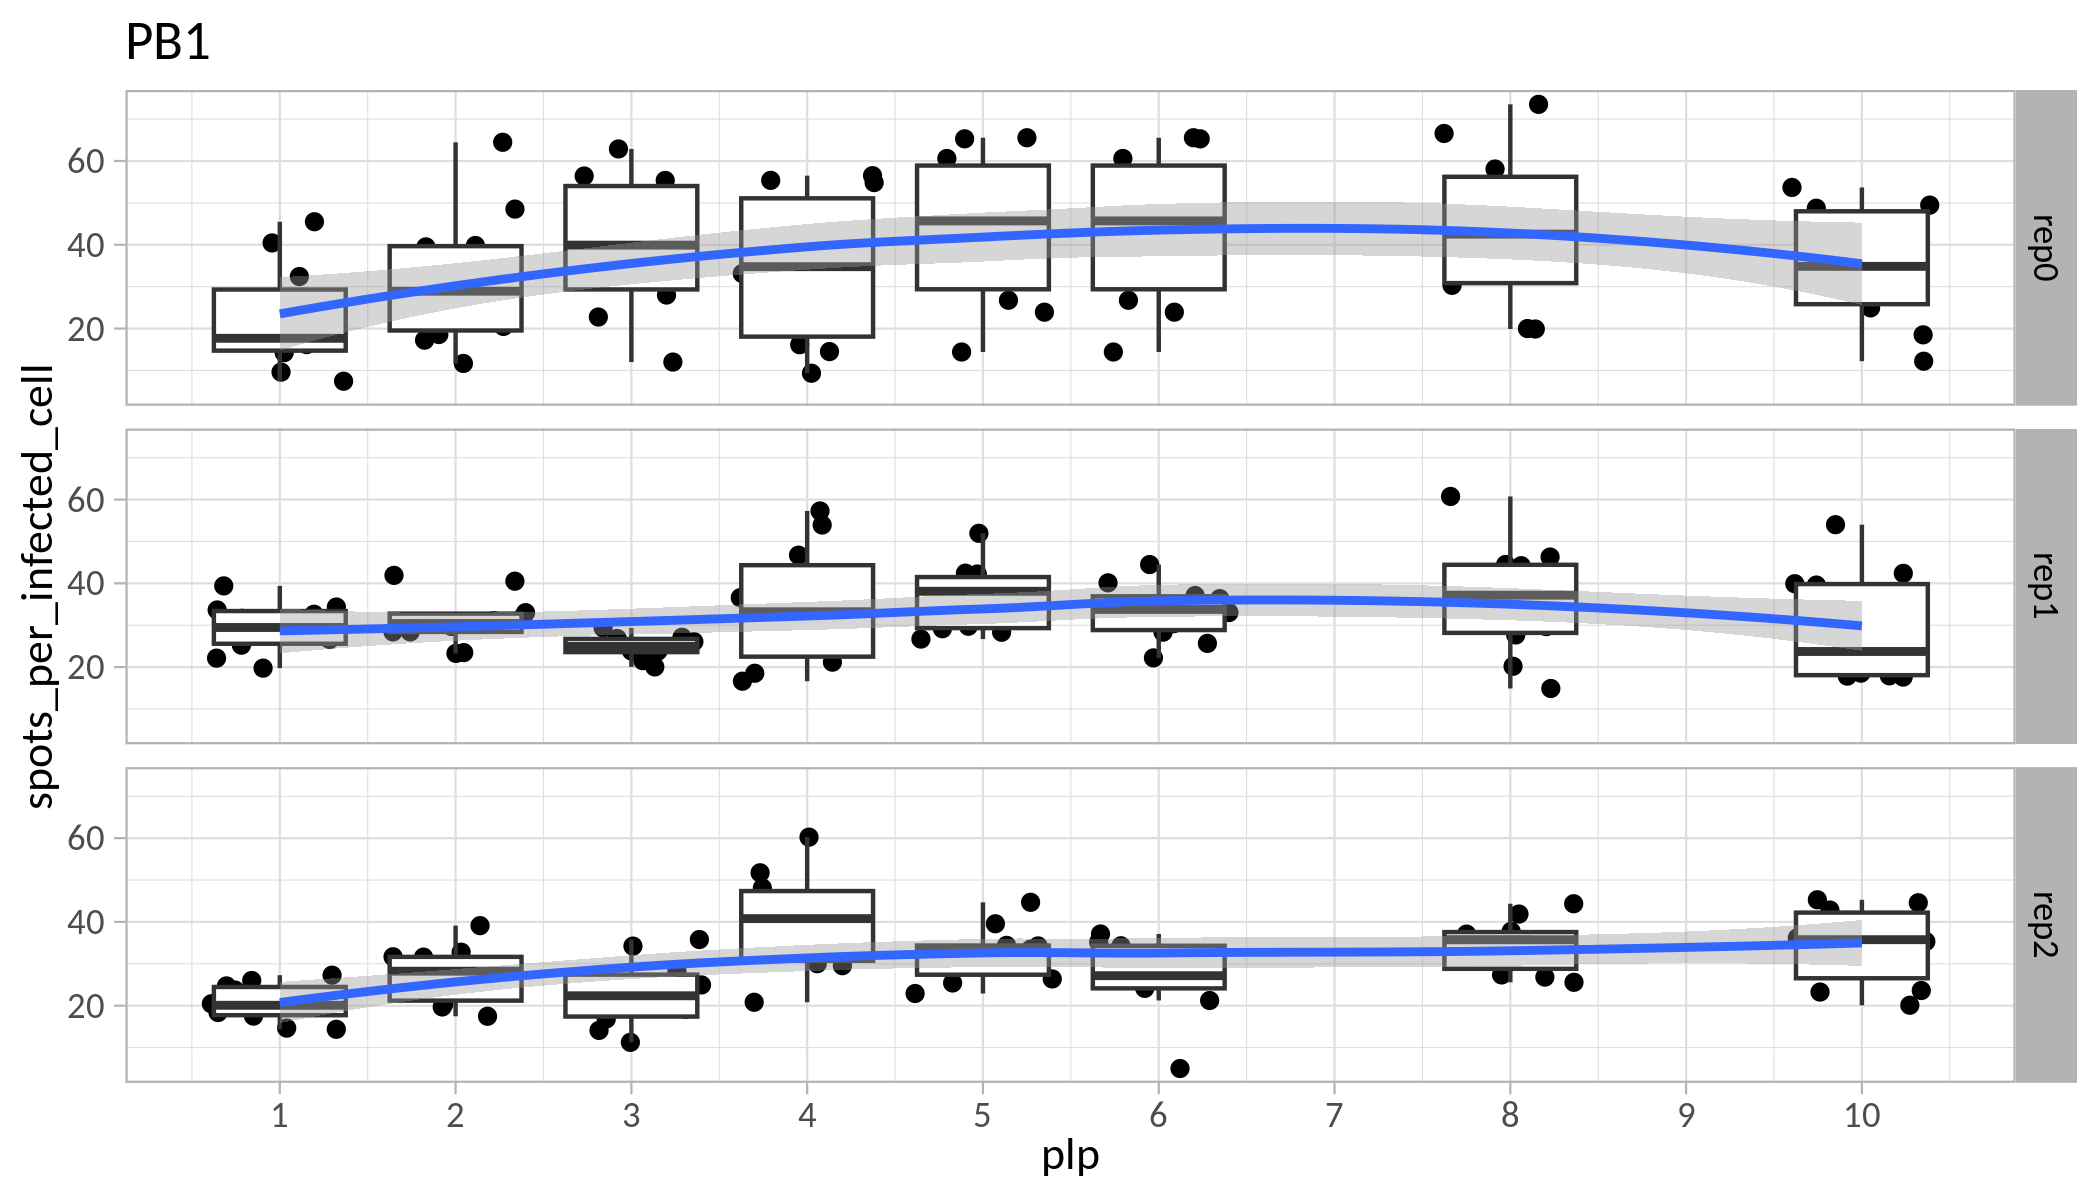

In [27]:
for (s in c("HA", "NA", "PB1")){
  print(pos_spots_summary %>%
          filter(segment == s) %>%
          mutate(plp = parse_number(sample)) %>%
          ggplot(aes(plp, spots_per_infected_cell)) +
          geom_jitter() +
          geom_boxplot(aes(group = plp), outlier.shape = NA) +
          geom_smooth(span = 1) +
          facet_grid(rep ~ .) +
          ggtitle(s) +
          scale_x_continuous(breaks = seq(1, 10, by = 1)) +
          NULL)
}

## <a id='toc1_5_'></a>[Median spot intensity](#toc0_)

### <a id='toc1_5_1_'></a>[QC intensity outliers](#toc0_)



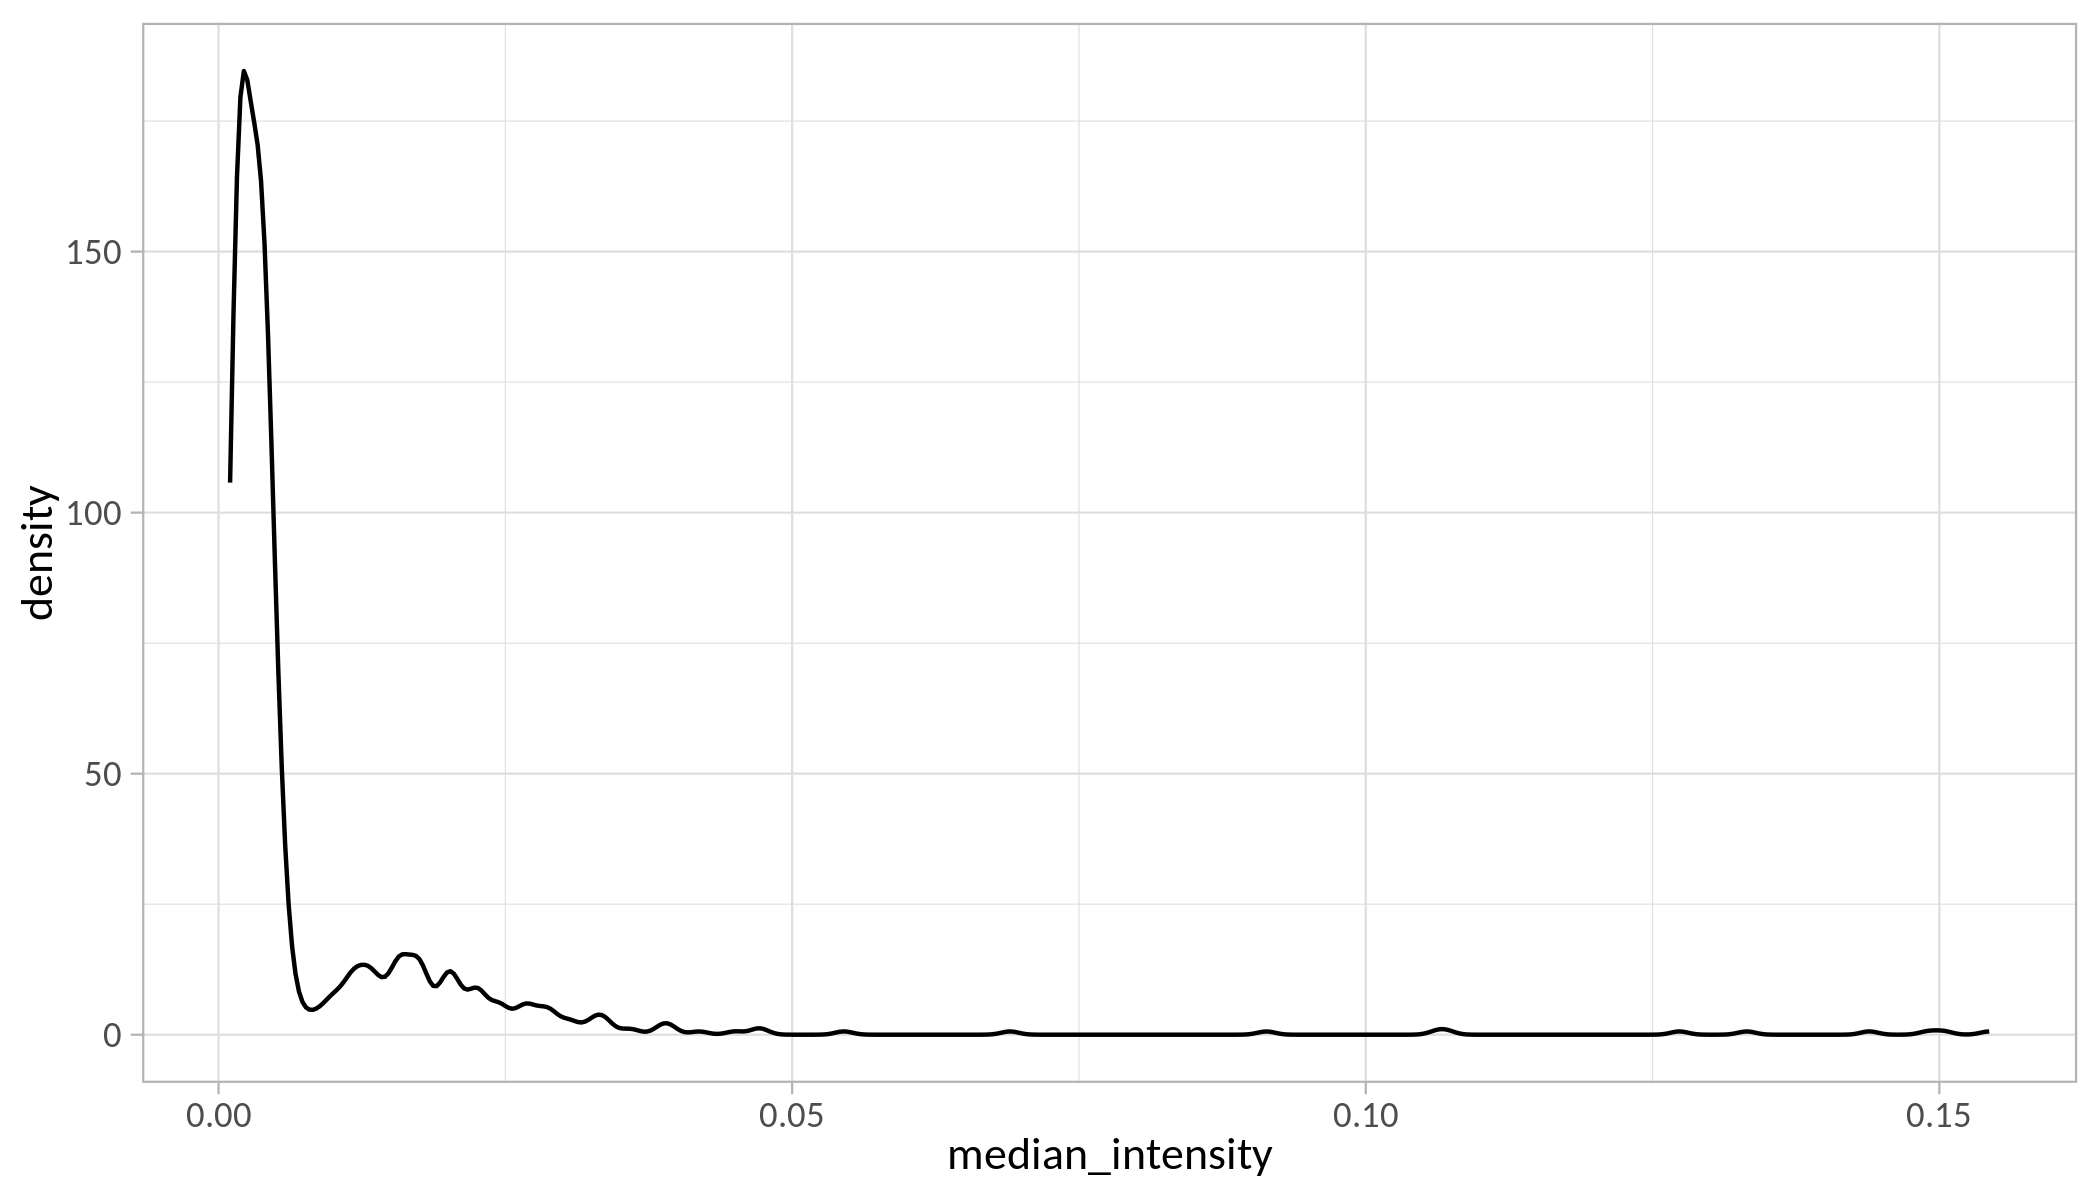

In [28]:
pos_spots_summary %>%
	ggplot(aes(x=median_intensity)) + 
		geom_density()
		#facet_grid(segment~sample) +
		#ggtitle("Median spot intensity")

In [29]:
pos_spots_summary %>% filter(median_intensity > 0.1)

rep,segment,sample,fov,infected_cells,spots,median_intensity,mean_radius,spots_per_infected_cell
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
rep0,NA,10PLP,fov_1,41,1978,0.1062486,3,48.24390
rep0,NA,10PLP,fov_2,40,2336,0.1438926,3,58.40000
rep0,NA,4PLP,fov_0,55,2275,0.1490196,3,41.36364
rep0,NA,4PLP,fov_1,29,1616,0.1543450,3,55.72414
rep0,NA,4PLP,fov_2,25,855,0.1503777,3,34.20000
rep0,NA,6PLP,fov_0,28,1605,0.1273365,3,57.32143
rep0,NA,6PLP,fov_1,31,1474,0.1070573,3,47.54839
rep0,NA,6PLP,fov_2,40,2022,0.1332113,3,50.55000


There are few samples with much higher (factor 5) median spot intensity, but it does not look concerning.

### <a id='toc1_5_2_'></a>[Spot intensity by PLP count](#toc0_)

In [30]:
pos_spots <- mutate(ungroup(pos_spots), sample=fct_reorder(sample, parse_number(sample)))

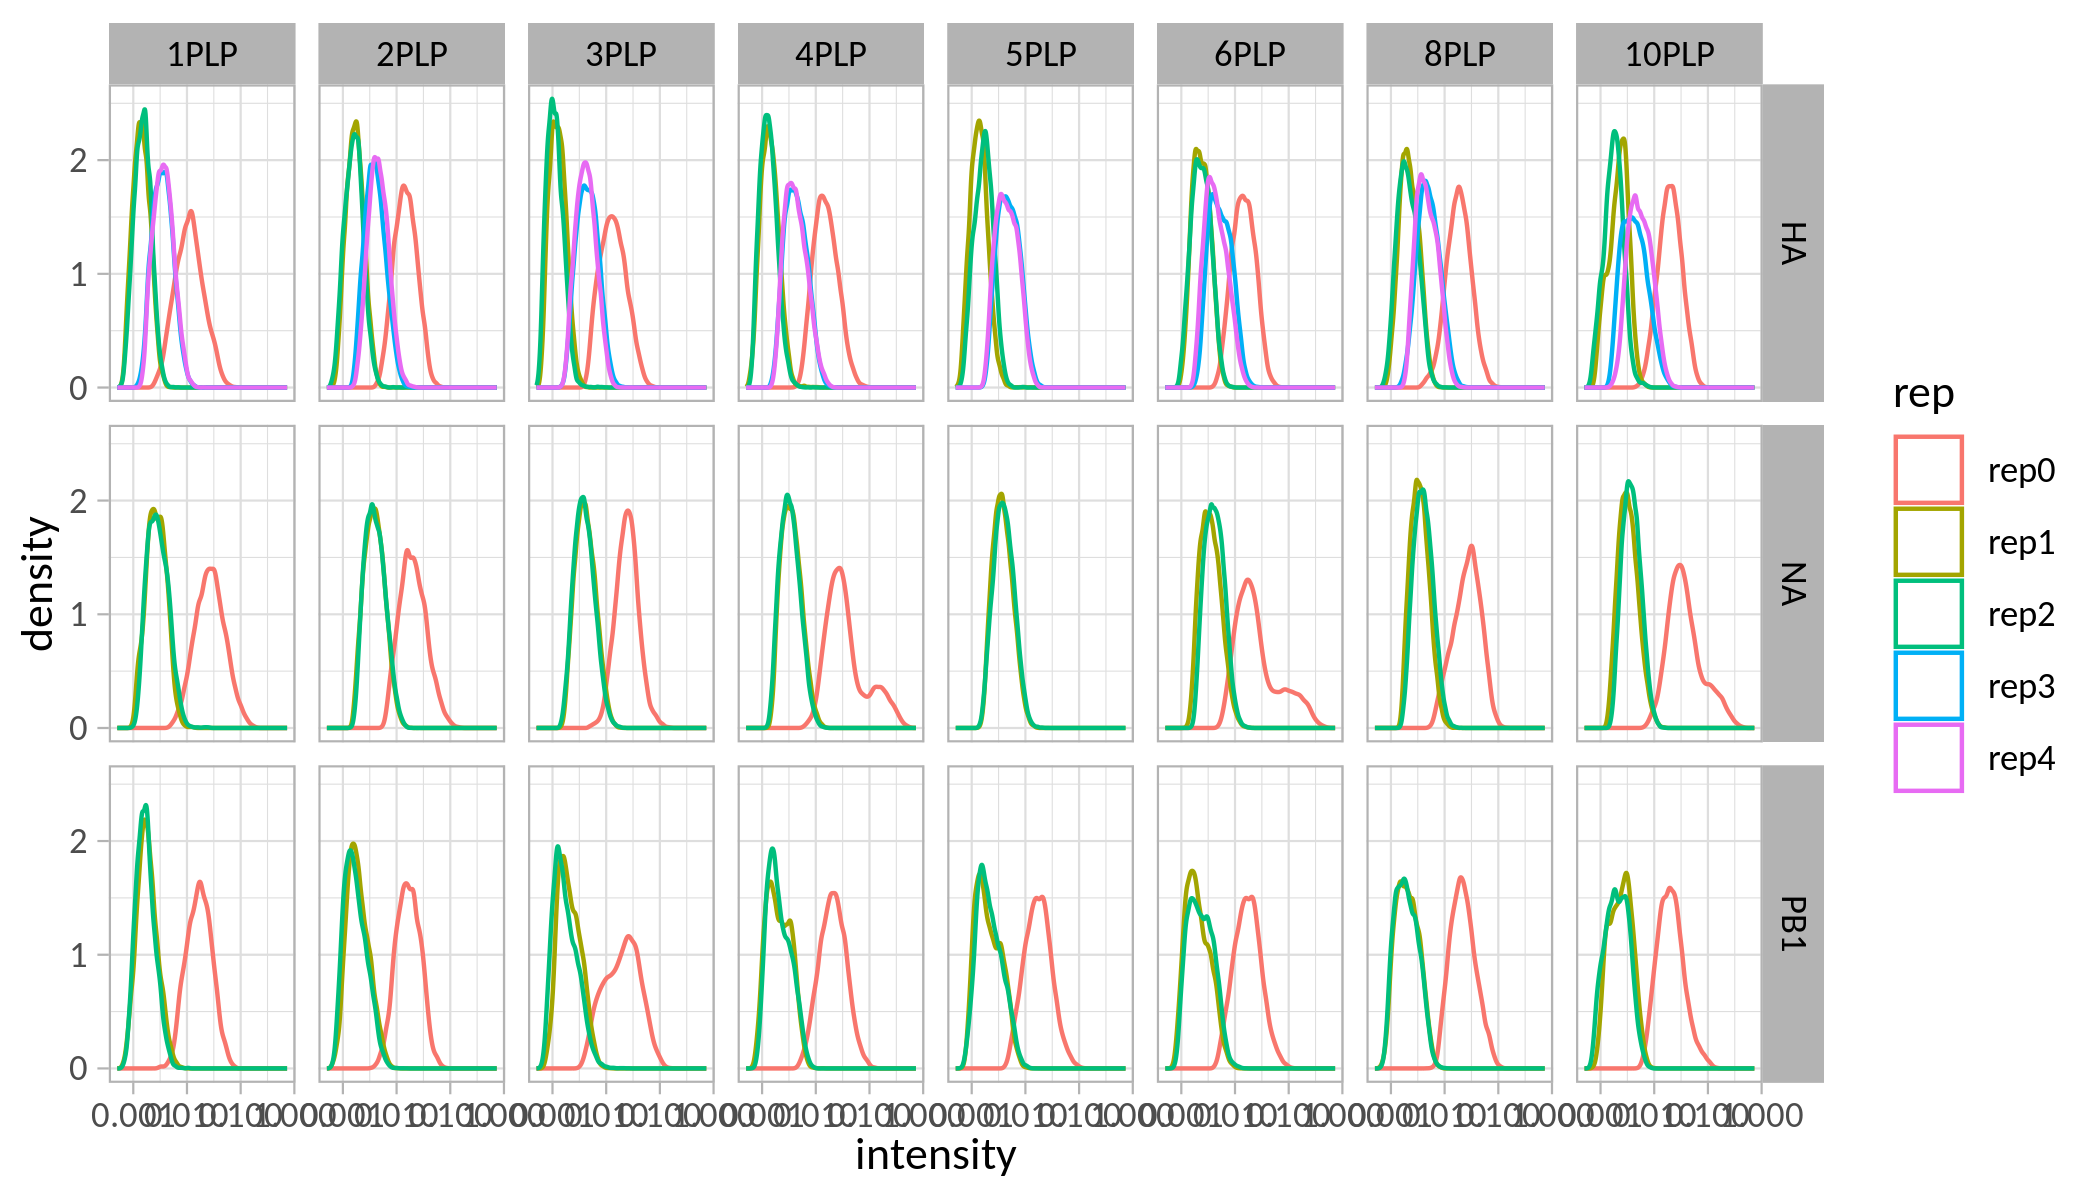

In [31]:
pos_spots %>%
	ggplot(aes(x=intensity, color=rep)) + 
		geom_density() +
		facet_grid(segment~sample) +
		scale_x_log10()
		#facet_grid(segment~sample) +
		#ggtitle("Median spot intensity")

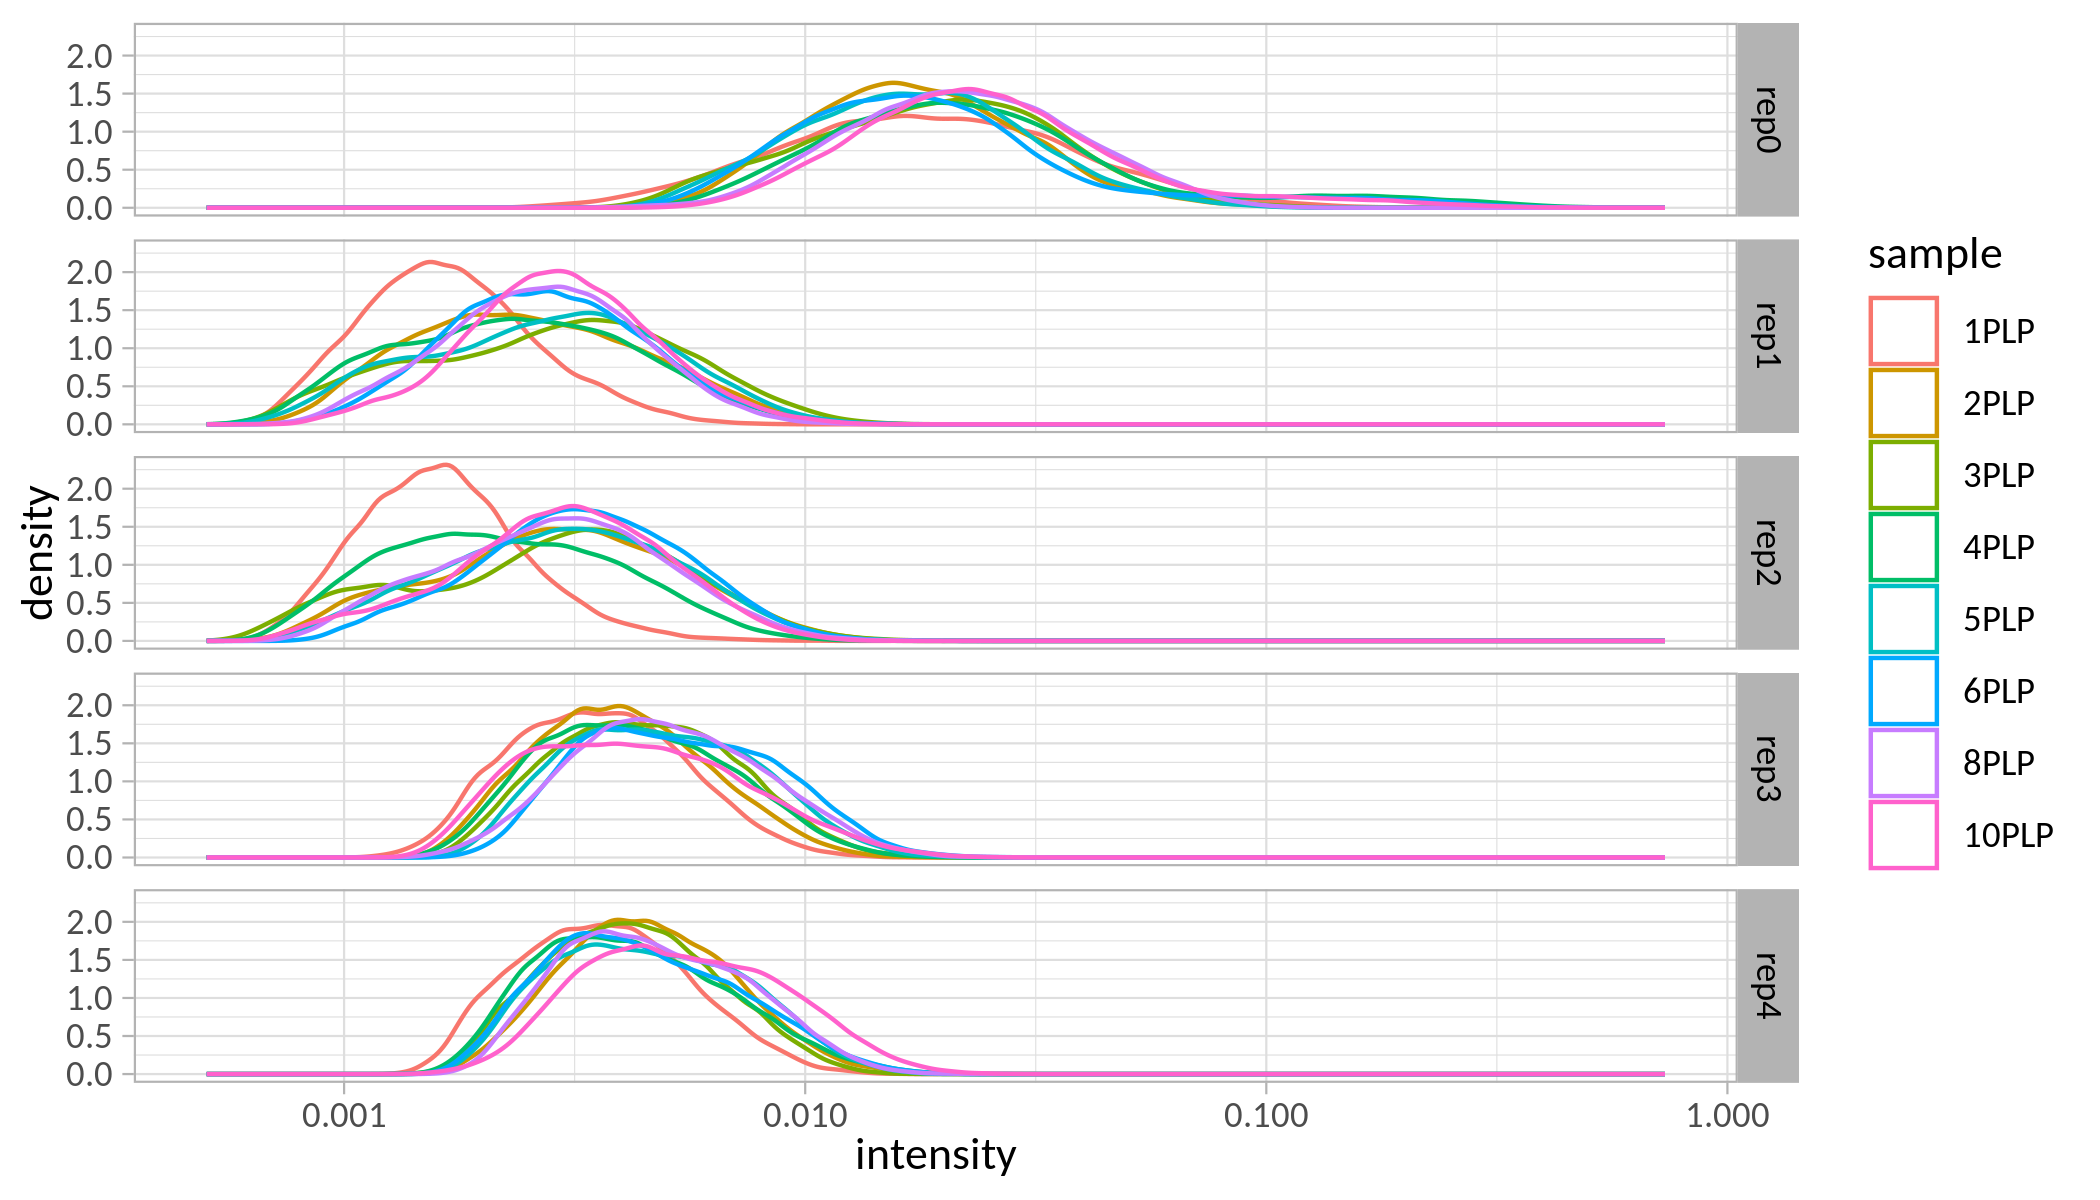

In [32]:
pos_spots %>%
	ggplot(aes(x=intensity, color=sample)) + 
		geom_density() +
		scale_x_log10() +
		facet_grid(rep~.)
		#ggtitle("Median spot intensity")

NULL

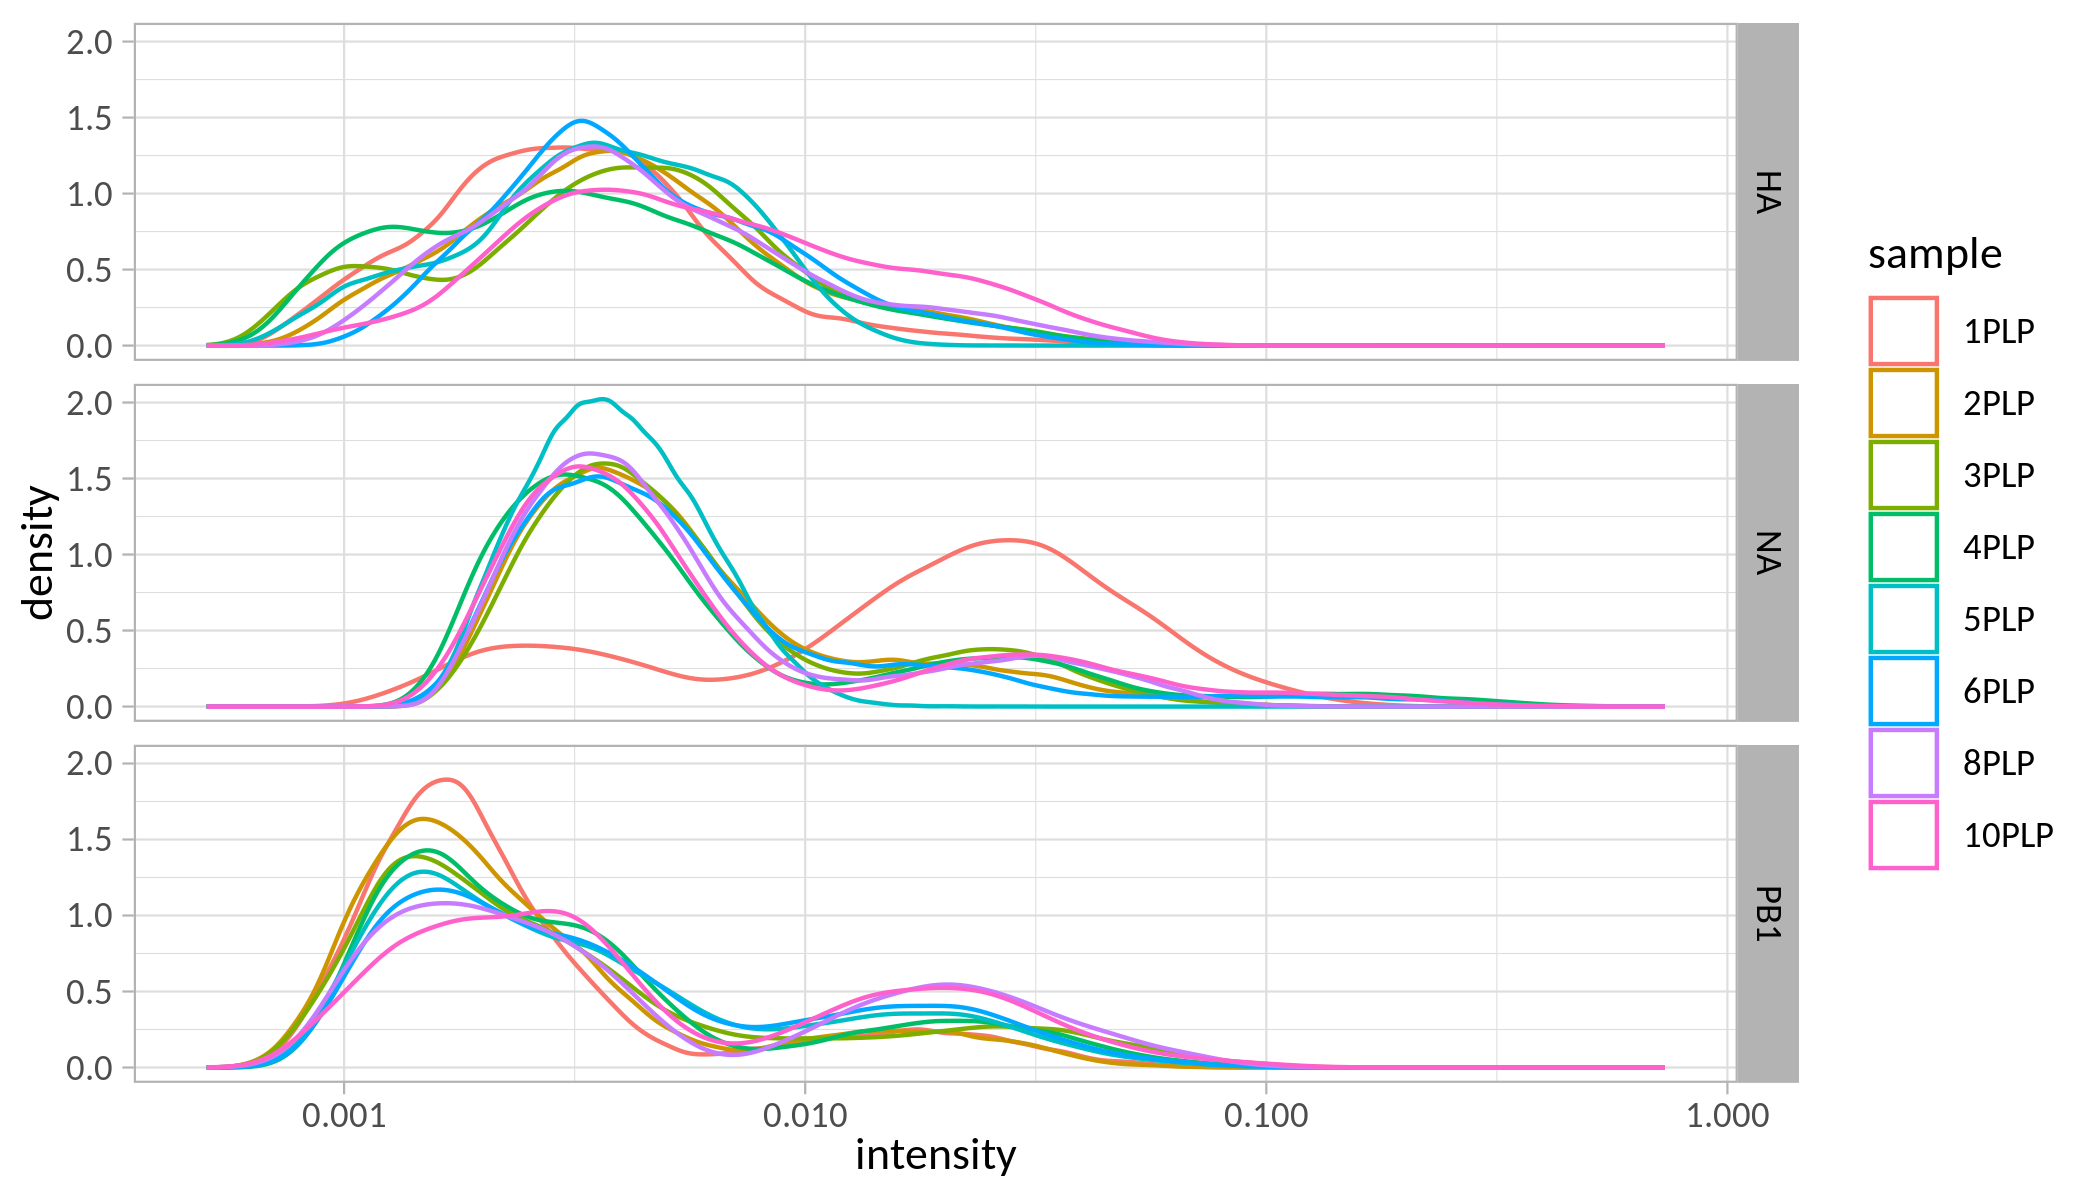

In [33]:
pos_spots %>%
	ggplot(aes(x=intensity, color=sample)) + 
		geom_density() +
		scale_x_log10() +
		facet_grid(segment~.)
		#ggtitle("Median spot intensity")
		NULL

There seems to be a small tendency towards higher spot intensity for larger PLP counts for HA and PB1, for NA the pattern is less clear with 1PLP as an outlier.